<a href="https://colab.research.google.com/github/olesyaRU/OlesyaRepository/blob/main/2_ML_DT%26RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Бинарная классификация**
## **Задача**. По данным о пациенте из файла **heart_data.tsv** научиться предсказывать наличие у него сердечно-сосудистого заболевания: артериальной гипертензии, ОНМК, сердечной недостаточности и др.

# Деревья решений, случайный лес

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Уберем предупреждения, чтобы они не загромождали вывод
import warnings
warnings.filterwarnings('ignore')

* Загрузим необходимые библиотеки

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)

from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV
)

from sklearn.model_selection import (
    StratifiedKFold,
    cross_validate,
    cross_val_score,
    KFold
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    multilabel_confusion_matrix,
    f1_score,
    auc,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    precision_recall_curve
)

from sklearn.tree import plot_tree  # Функция для визуализации структуры дерева решений

from tqdm import tqdm               # Библиотека для добавления индикаторов выполнения для циклов

from scipy.stats import (           # Модули для работы с распределениями, позволяющие генерировать
    uniform,                        # выборки из равномерного
    randint                         # и дискретного равномерного распределений
)

# Функция для оценки важности признаков, основанная на изменении точности модели при перестановке значений признаков
from sklearn.inspection import permutation_importance

* Загрузим набор данных, после проведённого разведочного анализа (тот, в котором 7 категориальных признаков были закодированы по методу **OneHot**)

In [ ]:
heart = pd.read_csv('/content/drive/MyDrive/ML_MED/heart_2.csv')
targets = ['ОНМК', 'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность',
           'Прочие заболевания сердца']
heart.head(3).T

,0,1,2
Пол,0,1,1
Образование,3,5,5
Работа,1,0,0
Выход на пенсию,0,0,0
Прекращение работы по болезни,0,0,0
...,...,...,...
Профессия_техники и младшие специалисты,0,0,0
Статус Курения_Бросил(а),0,0,0
Статус Курения_Курит,1,0,0
Алкоголь_ранее употреблял,0,0,0


## Построение модели предсказания

Предсказывать будем снова **Артериальную гипертензию**

In [ ]:
heart.drop(columns=targets, inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
heart.drop("Артериальная гипертензия", axis=1),
heart["Артериальная гипертензия"],
test_size=0.2,
random_state=42,
stratify=heart["Артериальная гипертензия"]
)

Класс **DecisionTreeClassifier** из библиотеки **scikit-learn** используется для создания и обучения классификационных деревьев решений. Он имеет множество аргументов, которые позволяют настраивать различные аспекты процесса обучения и работы модели:
* **criterion**: критерий, используемый для определения лучшего разделения на каждом уровне дерева. Доступны два варианта: 'gini' и 'entropy'
* **max_depth**: максимальная глубина дерева. Если значение равно None, то дерево будет расти бесконечно (по умолчанию не ограничено)
* **min_samples_split**: минимальное количество наблюдений, необходимое для разделения узла (по умолчанию 2)
* **min_samples_leaf**: минимальное количество наблюдений в листе (по умолчанию 1)
* **min_weight_fraction_leaf**: минимальная доля весов наблюдений в листе
* **max_features**: количество признаков, рассматриваемых при поиске лучшего разделения
* **max_leaf_nodes**: максимальное количество листьев в дереве (по умолчанию не ограничено)
* **class_weight**: вес классов, который может быть использован для балансировки несбалансированных наборов данных
* **random_state**: случайное состояние, используемое для воспроизводимости результатов
* **presort**: флаг, указывающий, следует ли предварительно сортировать признаки перед поиском лучшего разделения
* **min_impurity_decrease** - минимальное уменьшение загрязненности (по умолчанию 0)
* **ccp_alpha** - коэффициент для подрезки дерева (по умолчанию 0)


* Обучим классификатор, основанный на дереве решений

In [ ]:
model = DecisionTreeClassifier(random_state=42)
model= model.fit(X_train, y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

In [ ]:
train_probs = model.predict_proba(X_train)[:, 1]  # Вероятности положительного класса для обучающей выборки
test_probs = model.predict_proba(X_test)[:, 1]    # Вероятности положительного класса для тестовой выборки

In [ ]:
def evaluate_model(X_train, X_test, y_train, y_test, train_preds, test_preds, train_probs, test_probs):
    # Определяем метрики и соответствующие функции из sklearn
    metric_functions = {
        'Accuracy (достоверность)': (metrics.accuracy_score, {}),
        'Balanced Accuracy (сбалансированная достоверность)': (metrics.balanced_accuracy_score, {}),
        'Precision (точность)': (metrics.precision_score, {'average': 'weighted'}),
        'Recall (полнота)': (metrics.recall_score, {}),
        'F1 score (F1-мера)': (metrics.f1_score, {'average': 'weighted'}),
        'Specificity (специфичность)': (specificity, {'y_true': y_train, 'preds': train_preds}),
        'ROC AUC': (metrics.roc_auc_score, {}),
        'PR AUC': (metrics.average_precision_score, {})
    }

    # Цикл по наборам и метрикам
    for dataset_name, (y_true, preds, probs) in zip(['тренировочной', 'тестовой'],
                                                      [(y_train, train_preds, train_probs),
                                                       (y_test, test_preds, test_probs)]):
        print(f'Метрики на {dataset_name} выборке:')
        for metric_name, (metric_func, kwargs) in metric_functions.items():
            if metric_name in ['ROC AUC', 'PR AUC']:
                score = metric_func(y_true, probs)
            elif metric_name == 'Specificity (специфичность)':
                score = metric_func(y_true, preds)
            else:
                score = metric_func(y_true, preds, **kwargs)
            print(f'{metric_name}: {score:.4f}')
        print()  # Пустая строка для разделения выводов

In [ ]:
def specificity(y_true, preds):
    # Вычисляем специфичность
    tn = np.sum((y_true == 0) & (preds == 0))  # Истинно отрицательные
    fp = np.sum((y_true == 0) & (preds == 1))  # Ложно положительные
    return tn / (tn + fp) if (tn + fp) > 0 else 0

In [ ]:
evaluate_model(X_train, X_test, y_train, y_test, train_preds, test_preds, train_probs, test_probs)

Метрики на тренировочной выборке:
Accuracy (достоверность): 1.0000
Balanced Accuracy (сбалансированная достоверность): 1.0000
Precision (точность): 1.0000
Recall (полнота): 1.0000
F1 score (F1-мера): 1.0000
Specificity (специфичность): 1.0000
ROC AUC: 1.0000
PR AUC: 1.0000

Метрики на тестовой выборке:
Accuracy (достоверность): 0.6073
Balanced Accuracy (сбалансированная достоверность): 0.6094
Precision (точность): 0.6118
Recall (полнота): 0.6404
F1 score (F1-мера): 0.6076
Specificity (специфичность): 0.5784
ROC AUC: 0.6094
PR AUC: 0.5326



* Качество на тренировочной выборке равно единице (у логистической регрессии качество на тренировочной выборке мало отличалось от качества на тестовой).  Модель переобучилась, заучила ответы.
* Качество на тестовой выборке значительно хуже, чем у модели логистической регрессии.


* Визуализируем ROC- и PR-кривые.

In [ ]:
# import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

def plot_roc_pr_curves(y_test, test_probs):
    # ROC кривая
    fpr, tpr, _ = roc_curve(y_test, test_probs)
    roc_auc = auc(fpr, tpr)

    # PR кривая
    precision, recall, _ = precision_recall_curve(y_test, test_probs)
    pr_auc = average_precision_score(y_test, test_probs)

    plt.figure(figsize=(12, 5))

    # Подграфика для ROC кривой
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    # Подграфика для PR кривой
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall (PR) Curve')
    plt.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

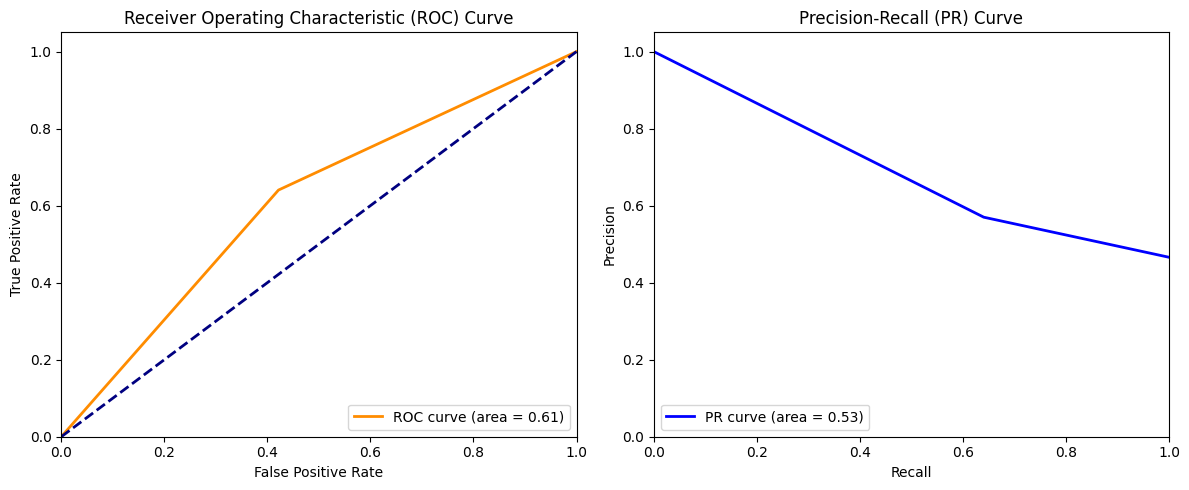

In [ ]:
plot_roc_pr_curves(y_test, test_probs)

### Визуализируем дерево решений

In [ ]:
arteria = heart.columns.drop('Артериальная гипертензия')

In [ ]:
# from sklearn.tree import plot_tree

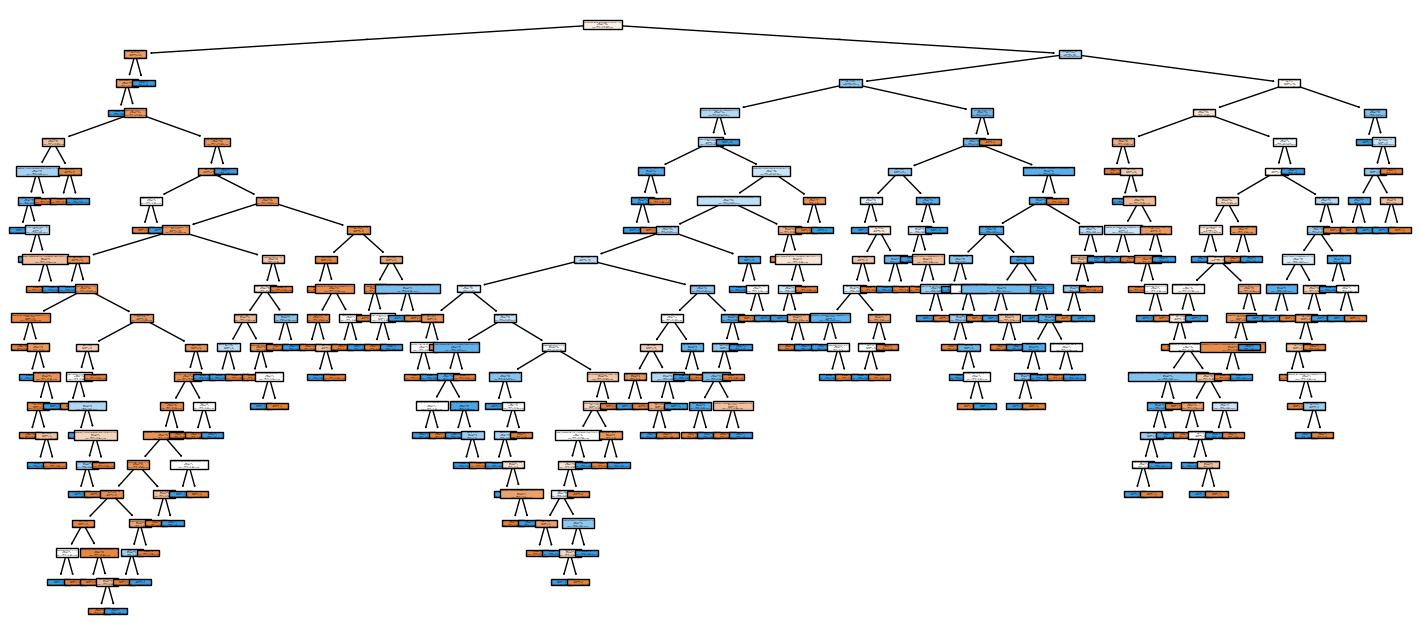

In [ ]:
plt.figure(figsize=(18, 8))
plot_tree(model,
          feature_names=arteria,
          class_names=['Нет арт.гипертензии', 'Есть арт.гипертензия'],
          filled=True)
plt.show()

* Посмотрим корень дерева и первый уровень

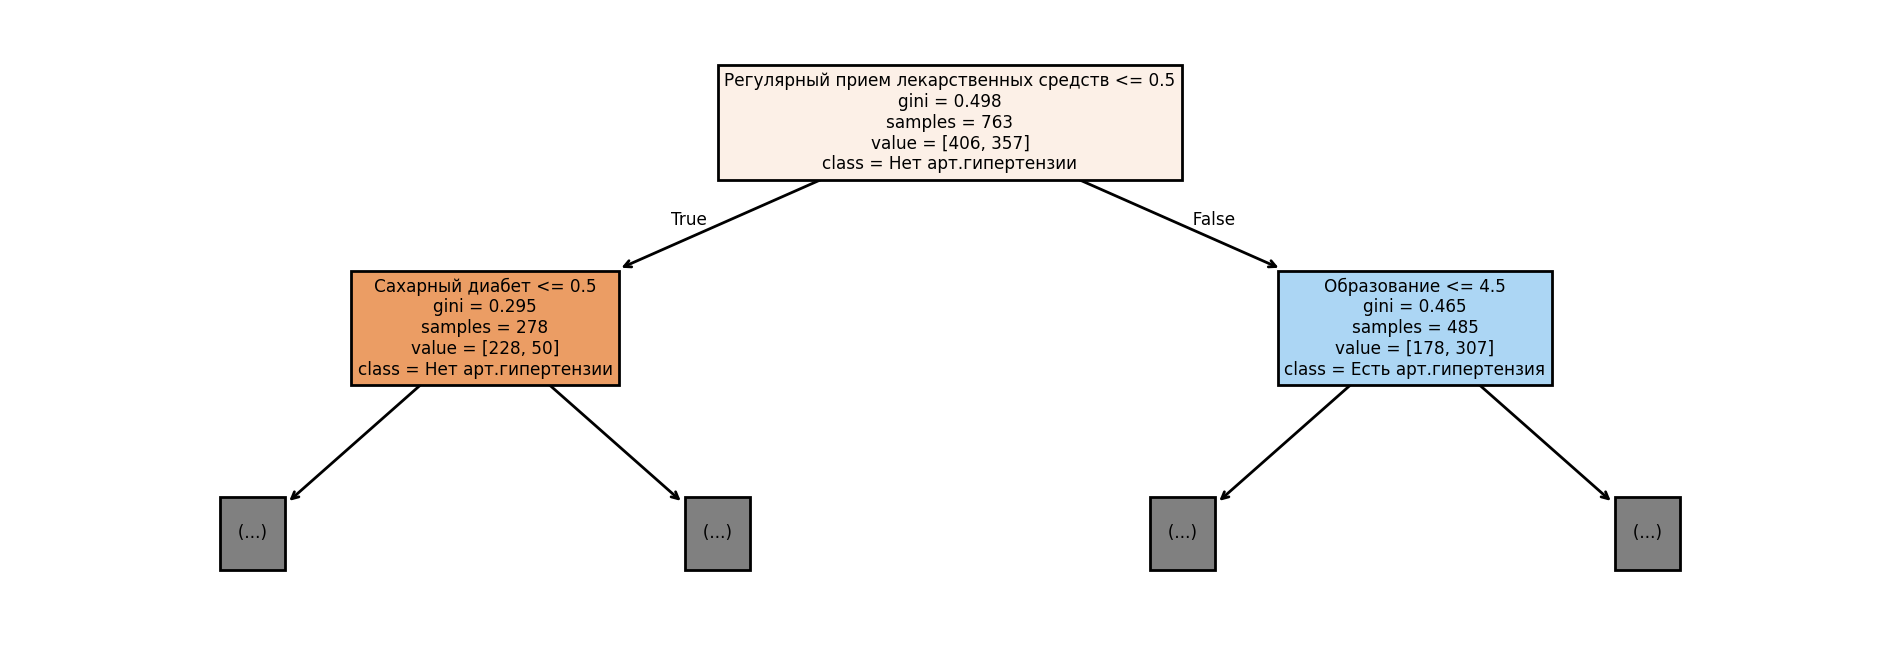

In [ ]:
plt.figure(figsize=(12, 4), dpi=200) #создает новый графический объект с размерами 12x4 единиц и разрешением 200 точек на дюйм
plot_tree(model, max_depth=1, #max_depth=1 - ограничивает глубину дерева решений до одного уровня
          feature_names=arteria, #задает имена признаков, которые будут использоваться для меток ветвей дерева
          class_names=['Нет арт.гипертензии', 'Есть арт.гипертензия'], #задает названия классов, которые будут использоваться в листьях дерева
          filled=True) #заполняет внутренние узлы дерева цветом
plt.show()

### Проанализируем информацию в корне дерева

* **Регулярный прием лекарственных средств <= 0.5** - критерий расщепления.
Объекты, у которых значение данного признака превышает пороговое значение 0.5, будут отнесены в правый узел, в то время как остальные попадут в левый. Анализируя распределение объектов между узлами, мы видим, что в левом узле находится 278 объектов, причем подавляющее большинство из них (228 против 50) не страдают от гипертензии. В правом узле, напротив, находится 485 объектов, и ситуация здесь обратная: 307 объектов имеют гипертензию, в то время как 178 - нет. Цвет узла в данной визуализации дополнительно указывает на вероятность наличия гипертензии.
* **samples = 763** - количество объектов в обучающей выборке.
* **value = [406, 357]** - сейчас в  выборке 406 пациентов без артериальной гипертензии (0) и 357 с артериальной гипертензией (1).
* **class = Нет гипертензии** - если бы нам пришлось прямо сейчас сделать прогноз относительно наличия артериальной гипертензии у человека, не имея никакой дополнительной информации о нем, основываясь исключительно на нашем наборе данных, мы бы пришли к выводу, что люди без гипертензии встречаются немного чаще (406 против 357 случаев), и поэтому, основываясь на "голосовании", мы бы ответили - **Нет арт.гипертензии**.

Разделив нашу выборку пациентов по критерию приема лекарств, мы получаем две, в некотором смысле, более чистые подвыборки. Затем мы продолжим разбивать эти подвыборки по другим критериям (например, в левом узле по критерию "Сахарный диабет <= 0.5", а в правом узле по критерию "Образование <= 4.5"), пока не получим абсолютно чистые подвыборки в листьях, то есть подвыборки, состоящие только из людей с артериальной гипертензией или без нее. Даже если такая подвыборка будет состоять всего из одного человека.

* Разберемся, как выбрать критерии для разбиения, чтобы построить дерево, и что значит **gini = 0.498**.

Деревья решений можно создать с помощью жадного переборного рекурсивного алгоритма. На каждом этапе в узле рассматриваются все возможные (оставшиеся) пороги для всех признаков, и выбирается наилучшее разделение.


### Оценка качества расщепления

Для оценки качества разбиения используется взвешенная сумма загрязненности получаемых подвыборок

$$Weighted Impurity Decrease = \frac{N_C}{N}*(Impurity_С-\frac{N_L}{N_C}*Impurity_L-\frac{N_R}{N_C}*Impurity_R)$$

где
* $N$ - количество объектов в начальном наборе данных
* $N_C$ - количество объектов в узле до расщепления
* $Impurity_С$ - загрязненность выборки в узле
* $N_R$ и $N_L$ - количество объектов в правом и левом узле после расщепления
* $Impurity_R$ и $Impurity_L$ - загрязненность выборок в правом и левом узле

 В качестве **меры загрязненности** $Impurity$ используются:
* **Критерий Джини** $$Gini = 1 - \sum_ip_i^2$$
* **Энтропия** $$Entropy = -\sum_{i}p_i log_2 (p_i)$$

где $p_i$ -  пропорция i-того класса в выборке.


Критерий Джини вычислительно проще Энтропии.

В контексте бинарной классификации, согласно критерию Джини, выборка считается абсолютно чистой, если в ней представлен только один класс.
$$1 - (1^2 + 0^2) = 0$$
И наоборот, выборка считается абсолютно грязной, если оба класса представлены в равных пропорциях.
$$1 - (0.5^2 + 0.5^2) = 0.5$$
Следовательно, максимальное значение критерия Джини при бинарной классификации составляет 0.5 и достигается, когда вероятность обоих классов в выборке одинакова.

* Вычислим **Критерий Джини** для корня нашего дерева

In [ ]:
round(1 - ((406 / 763) ** 2 + (357 / 763) ** 2), 3)

0.498

Деревья решений, в отличие от линейных алгоритмов, **не требуют стандартизации**.

Чтобы избежать переобучения можно использовать аргументы класса **DecisionTreeClassifier**


* Изменим гиперпараметр максимальная глубина дерева **max_depth**.

In [ ]:
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model= model.fit(X_train, y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
train_probs = model.predict_proba(X_train)[:, 1]
test_probs = model.predict_proba(X_test)[:, 1]

In [ ]:
evaluate_model(X_train, X_test, y_train, y_test, train_preds, test_preds, train_probs, test_probs)

Метрики на тренировочной выборке:
Accuracy (достоверность): 0.7418
Balanced Accuracy (сбалансированная достоверность): 0.7427
Precision (точность): 0.7437
Recall (полнота): 0.7563
F1 score (F1-мера): 0.7421
Specificity (специфичность): 0.7291
ROC AUC: 0.8197
PR AUC: 0.7709

Метрики на тестовой выборке:
Accuracy (достоверность): 0.6754
Balanced Accuracy (сбалансированная достоверность): 0.6753
Precision (точность): 0.6766
Recall (полнота): 0.6742
F1 score (F1-мера): 0.6757
Specificity (специфичность): 0.6765
ROC AUC: 0.7471
PR AUC: 0.6557



Алгоритм меньше заучил тренировочные данные и получил бОльшую предсказательную способность на тестовых данных.

* Визуализируем наше дерево

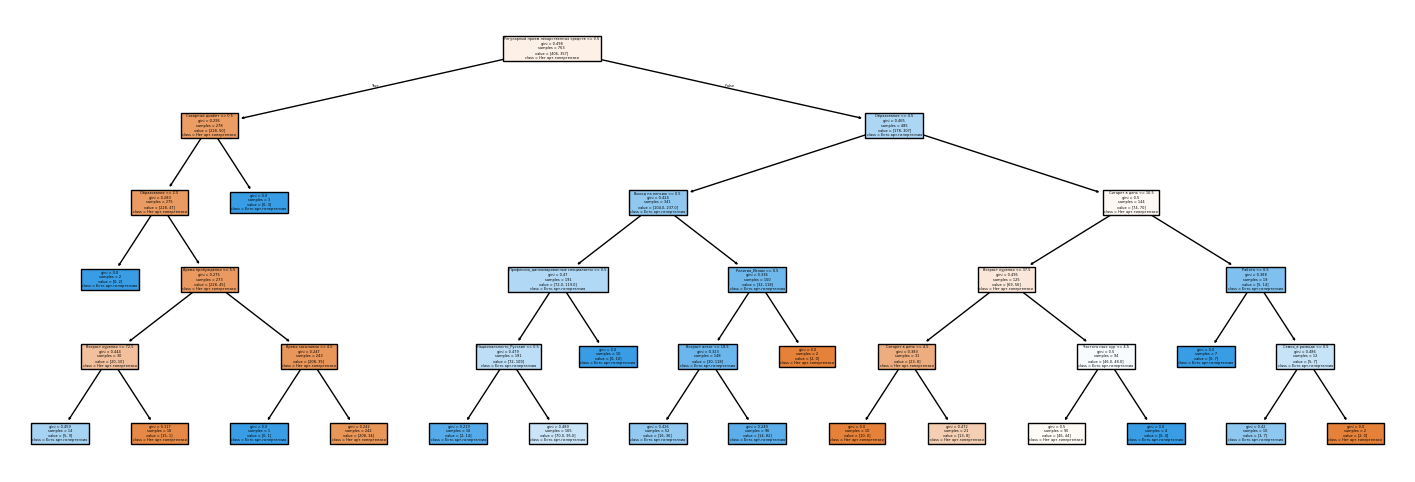

In [ ]:
plt.figure(figsize=(18, 6))
plot_tree(model,
          feature_names=arteria,
          class_names=['Нет арт.гипертензии', 'Есть арт.гипертензия'],
          filled=True)
plt.show()

Очевидно, что существует оптимальный набор гиперпараметров, который позволит построить наилучшее дерево.

Рассмотрим влияние одного из этих параметров на результаты модели. В качестве примера возьмем гиперпараметр **min_samples_leaf** (минимальное количество объектов в листе)

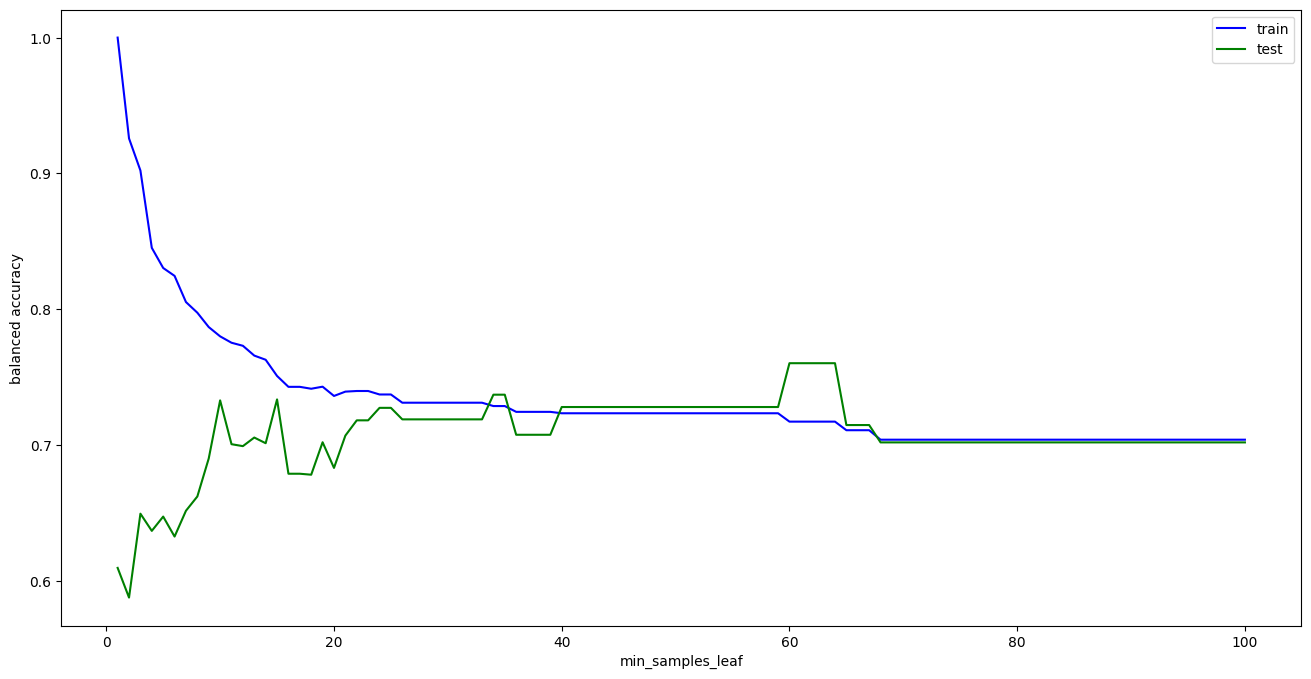

In [ ]:
train_balans = [] # Создаёт пустой список для хранения сбалансированных метрик точности на тренировочном наборе данных
test_balans = [] # Создаёт пустой список для хранения сбалансированных метрик точности на тестовом наборе данных
values = list(range(1, 101)) # Создаёт список значений от 1 до 100, которые будут использованы
                             # в качестве значений гиперпараметра min_samples_leaf для дерева решений
for min_samples_leaf in values: # Для каждого значения min_samples_leaf в списке, выполняет следующие шаги:
    model = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, random_state=42) # Создаёт экземпляр класса DecisionTreeClassifier
                          # с заданным значением min_samples_leaf и фиксированным состоянием случайности (для воспроизводимости результатов)
    model = model.fit(X_train, y_train) # Обучает модель на тренировочных данных, используя признаки из столбца arteria
                                                               # и целевую переменную из столбца target
    train_preds = model.predict(X_train) # Делает предсказания на тренировочных данных и сохраняет их в train_preds
    test_preds = model.predict(X_test) # Делает предсказания на тестовых данных и сохраняет их в test_preds
    train_balans.append(balanced_accuracy_score(y_train, train_preds)) # Добавляет сбалансированную метрику точности для тренировочных данных
                                                                             # в список train_balans
    test_balans.append(balanced_accuracy_score(y_test, test_preds)) # Добавляет cбалансированную метрику точности для тестовых данных в список test_balans


# Cоздание графика c двумя линиями, где по оси X отложены значения min_samples_leaf,по Y - cбалансированные метрики точности для тренировочных и тестовых данных
plt.figure(figsize=(16, 8))
plt.plot(values, train_balans, label='train', color='blue') # Линия для тренировочных данных синего цвета
plt.plot(values, test_balans, label='test', color='green') # Линия для тестовых данных - зеленого
plt.xlabel('min_samples_leaf')
plt.ylabel('balanced accuracy')
plt.legend() # Добавляет легенду
plt.show()

 Подбор гиперпараметров модели и тестирование на тех же данных приводят к переобучению.
Чтобы избежать этого используем на тренировочной выборке **кросс-валидацию**.

## **Кросс-валидация**

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" alt="Drawing" style="width: 600px;"/>

### **StratifiedKFold**

**StratifiedKFold** (Stratified K-Fold Cross-Validation) представляет собой важный инструмент в области машинного обучения, позволяющий более точно оценивать модели, особенно при работе с несбалансированными данными. Данный метод делит исходный набор данных на k равных частей (фолдов), сохраняя при этом пропорции классов в каждой из них. Это означает, что в каждом фолде будет представлено то же соотношение классов, что и в исходном наборе данных, что способствует более честной и точной оценке качества модели.

**Принципы работы**

Основной идеей работы StratifiedKFold является избегание ситуации, когда один или несколько фолдов могут оказаться существенно недопредставленными в определенных классах. Такой подход позволяет минимизировать смещение в оценках производительности, обеспечивая, что каждый фолд является репрезентативным для всего набора данных.

Работа метода включает несколько этапов:

1. **Разделение данных**: исходный набор данных делится на k фолдов таким образом, чтобы в каждом фолде сохранялся аналогичный состав.
  
2. **Обучение и тестирование модели**: в ходе выполнения кросс-валидации модель обучается на (k-1) фолдах, а тестируется на оставшемся фолде. Этот процесс повторяется k раз с тем, чтобы каждый фолд использовался в качестве тестового ровно один раз.

3. **Сбор результатов**: после выполнения всех итераций результаты оценок (например, точность, F1-мера и т. д.) агрегируются для получения окончательной метрики качества модели.

**Аргументы метода**

Метод **StratifiedKFold** в **Python** обычно реализуется через библиотеку **Scikit-learn** и принимает несколько ключевых аргументов:

- **n_splits**: количество фолдов, на которые необходимо разбить данные. Это целочисленный аргумент, который указывает, на сколько частей будет разделен набор данных. Значение должно быть больше 1.

- **shuffle**: булевый параметр, который указывает, следует ли перемешивать данные перед их разделением. Если установлено True, данные перемешиваются, что может повысить репрезентативность выборок, особенно при наличии упорядоченных данных.

- **random_state**: аргумент, который задает семя генератора случайных чисел для повторяемости результатов. Передав одно и то же значение, можно гарантировать, что результаты будут одинаковыми при многократных запусках.

In [ ]:
model = DecisionTreeClassifier(random_state=42)

# Инициализируем StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Выполним кросс-валидацию и получим оценки точности
cv_results = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')

* Посмотрим результаты кросс-валидации:

In [ ]:
print(cv_results)

[0.5751634  0.5620915  0.64052288 0.61842105 0.53947368]


In [ ]:
print(cv_results.mean())

0.5871345029239766


Для специфичности, ROC AUC и PR AUC кросс-валидация обычно не делается, но это зависит от вашей задачи.


In [ ]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score
# from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix

def getScores(estimator, x, y):
    # Получаем предсказанные классы
    y_pred = estimator.predict(x)

    # Получаем предсказанные вероятности
    y_pred_prob = estimator.predict_proba(x)[:, 1]

    # Основные метрики
    accuracy = accuracy_score(y, y_pred).round(5)
    precision = precision_score(y, y_pred).round(5)
    recall = recall_score(y, y_pred).round(5)
    balanced_accuracy = balanced_accuracy_score(y, y_pred).round(5)
    f1 = f1_score(y, y_pred).round(5)

    # Матрица ошибок для специфичности
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    specificity = (tn / (tn + fp)).round(5)

    # ROC AUC и PR AUC
    roc_auc = roc_auc_score(y, y_pred_prob).round(5)
    pr_auc = average_precision_score(y, y_pred_prob).round(5)

    return (accuracy, precision, recall, balanced_accuracy, f1, specificity, roc_auc, pr_auc)

def my_scorer(estimator, x, y):
    a, p, r, b, f, s, roc, pr = getScores(estimator, x, y)
    print(f'accuracy: {a}, precision: {p}, recall: {r}, balanced_accuracy: {b}, F1_score: {f}, specificity: {s}, ROC AUC: {roc}, PR AUC:{pr}')
    return a+p+r+b+f+s+roc+pr

In [ ]:
scores = cross_val_score(model,X=X_train, y=y_train,cv=skf, scoring=my_scorer)

In [ ]:
model = model.fit(X_train, y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
train_probs = model.predict_proba(X_train)[:, 1]
test_probs = model.predict_proba(X_test)[:, 1]

In [ ]:
evaluate_model(X_train, X_test, y_train, y_test, train_preds, test_preds, train_probs, test_probs)

Метрики на тренировочной выборке:
Accuracy (достоверность): 1.0000
Balanced Accuracy (сбалансированная достоверность): 1.0000
Precision (точность): 1.0000
Recall (полнота): 1.0000
F1 score (F1-мера): 1.0000
Specificity (специфичность): 1.0000
ROC AUC: 1.0000
PR AUC: 1.0000

Метрики на тестовой выборке:
Accuracy (достоверность): 0.6073
Balanced Accuracy (сбалансированная достоверность): 0.6094
Precision (точность): 0.6118
Recall (полнота): 0.6404
F1 score (F1-мера): 0.6076
Specificity (специфичность): 0.5784
ROC AUC: 0.6094
PR AUC: 0.5326



* Вариант более компактной записи решения:

In [ ]:
# from sklearn.model_selection import cross_val_score
# Создадим модель классификатора
model = DecisionTreeClassifier(random_state=42)

# Инициализируем StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scor = ['accuracy','balanced_accuracy','precision', 'recall', 'f1']
for i in scor:
    # Выполним кросс-валидацию и получим оценки точности
    cv_results = cross_val_score(model, X_train, y_train, cv=skf, scoring=i).round(5)

    # Выведем результаты
    print(f'Результаты кросс-валидации {i}: {cv_results}')
    print(f'Средняя точность на тренировочной выборке для {i}: {np.mean(cv_results):.4f}',end='\n\n')

    # Обучим модель на всех тренировочных данных
    model.fit(X_train, y_train)

    # Прогнозы на тестовых данных
    y_pred = model.predict(X_test)

    # Оценка точности на тестовых данных
    if i == 'accuracy':
        test_score = accuracy_score(y_test, y_pred)
    elif i == 'balanced_accuracy':
        test_score = balanced_accuracy_score(y_test, y_pred)
    elif i == 'precision':
        test_score = precision_score(y_test, y_pred, average='weighted' )
    elif i == 'recall':
        test_score = recall_score(y_test, y_pred)
    elif i == 'f1':
        test_score = f1_score(y_test, y_pred, average='weighted' )

    print(f'{i.capitalize()} на тестовой выборке: {test_score:.4f}')
    print('-' * 80)

Результаты кросс-валидации accuracy: [0.57516 0.56209 0.64052 0.61842 0.53947]
Средняя точность на тренировочной выборке для accuracy: 0.5871

Accuracy на тестовой выборке: 0.6073
--------------------------------------------------------------------------------
Результаты кросс-валидации balanced_accuracy: [0.57716 0.5571  0.64291 0.6185  0.5366 ]
Средняя точность на тренировочной выборке для balanced_accuracy: 0.5865

Balanced_accuracy на тестовой выборке: 0.6094
--------------------------------------------------------------------------------
Результаты кросс-валидации precision: [0.54321 0.53968 0.6     0.58667 0.50725]
Средняя точность на тренировочной выборке для precision: 0.5554

Precision на тестовой выборке: 0.6118
--------------------------------------------------------------------------------
Результаты кросс-валидации recall: [0.61111 0.47222 0.67606 0.61972 0.49296]
Средняя точность на тренировочной выборке для recall: 0.5744

Recall на тестовой выборке: 0.6404
-------------

### **cross_validate**
Функция **cross_validate** из библиотеки **scikit-learn** позволяет оценить качество модели машинного обучения без необходимости её разделения на обучающую и тестовую выборки. Она автоматически разбивает исходные данные на несколько частей, обучается на одних и тестирует на других, и так несколько раз.

Функция **cross_validate** принимает следующие аргументы:
* **estimator**: экземпляр класса модели, которую нужно оценить
* **X**: матрица входных данных
* **y**: вектор целевых переменных
* **groups**: список групп, к которым относятся наблюдения
* **scoring**: функция оценки качества модели
* **cv**: объект кросс-валидации
* **n_jobs**: количество ядер процессора, которое можно использовать для параллельной обработки
* **verbose**: уровень вывода информации
* **error_score**: значение, которое будет возвращено, если модель не может быть обучена

После выполнения функции **cross_validate** возвращается словарь результатов, который содержит средние значения метрик оценки качества модели, стандартные отклонения этих метрик и другие полезные данные.

* Посмотрим как коэффициент подрезки дерева **ccp_alpha** и минимального уменьшения загрязненности **min_impurity_decrease** влияют на результаты модели.

Построим **график кросс-валидации**, показывающий среднюю балансированную точность и стандартное отклонение для тренировочных и валидационных наборов данных.

In [ ]:
# Определим функцию plot_cv_res, которая принимает четыре аргумента: values - список значений гиперпараметров,
# train_scores - список балансированных метрик точности для тренировочных наборов данных,
# val_scores - список балансированных метрик точности для валидационных наборов данных,
# name - имя параметра, которое будет использоваться в качестве метки оси X
def plot_cv_res(values, train_scores, val_scores, name):
# вычисляем среднее значение балансированных метрик точности по всем тренировочным наборам данных
    train_mean = np.mean(train_scores, axis=1)
# вычисляем стандартное отклонение балансированных метрик точности по всем тренировочным наборам данных
    train_std = np.std(train_scores, axis=1)
# вычисляем среднее значение балансированных метрик точности по всем валидационным наборам данных
    val_mean = np.mean(val_scores, axis=1)
# вычисляем стандартное отклонение балансированных метрик точности по всем валидационным наборам данных
    val_std = np.std(val_scores, axis=1)

# создаем новый график с размерами 16x8 единиц
    plt.figure(figsize=(16, 8))
# рисуем линию для тренировочных данных, используя синий цвет, кружки в качестве маркеров и размер маркера 5
    plt.plot(values, train_mean,
             color='blue', marker='o',
             markersize=5, label='Train')
# рисуем область неопределенности вокруг линии тренировочных данных с прозрачностью 0.15 синим цветом
    plt.fill_between(values,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')
# рисуем линию для валидационных данных, используя зеленый цвет, штрихпунктирную линию и ромбические маркеры
    plt.plot(values, val_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='Validation')
# рисуем область неопределенности вокруг линии валидационных данных с прозрачностью 0.15 зеленым цветом
    plt.fill_between(values,
                     val_mean + val_std,
                     val_mean - val_std,
                     alpha=0.15, color='green')
# включаем сетку на графике
    plt.grid()
# добавляем метку к оси X, используя имя параметра, переданное в функцию
    plt.xlabel(name)
# добавляем метку к оси Y, указывающую, что это балансовая точность
    plt.ylabel('Balanced Accuracy')
# добавляем легенду к графику
    plt.legend()
# отображаем график на экране
    plt.show()

Этот код выполняет кросс-валидацию с использованием параметра **ccp_alpha** для регуляризации дерева решений, вычисляя сбалансированную точность для обучающей и валидационной выборок. Результаты затем визуализируются на графике.
В коде производится перебор значений параметра **ccp_alpha** (который отвечает за обрезку (pruning) дерева), что позволяет оценить его влияние на сбалансированную точность модели.

100%|██████████| 100/100 [00:13<00:00,  7.56it/s]


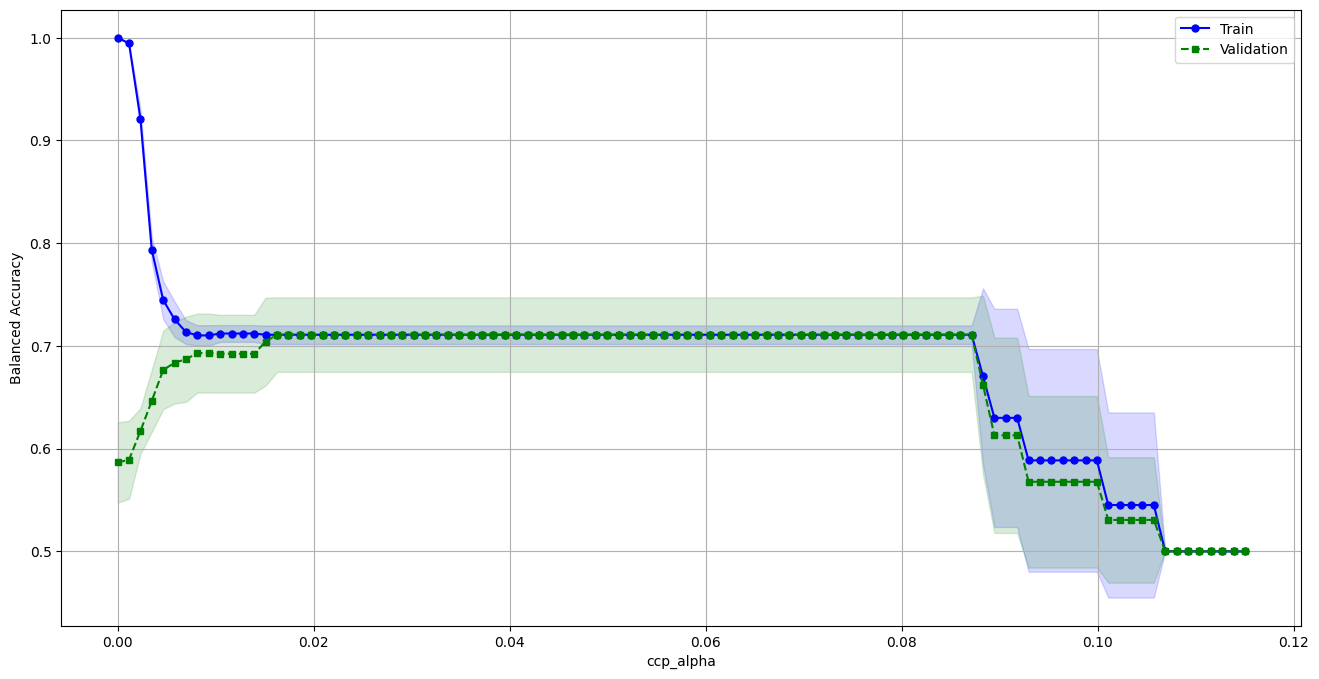

In [ ]:
# Создадим пустой список для хранения сбалансированных метрик точности на тренировочных и валидационных наборах данных:
train_balans = []
val_balans = []
# Создадим массив значений от 0 до 0.115 с шагом 0.001, который будет использован в качестве значений ccp_alpha:
values = np.linspace(0, 0.115, 100)
# Создадим цикл для перебора всех значений ccp_alpha, использование tqdm позволяет отслеживать прогресс выполнения цикла:
for ccp_alpha in tqdm(values):
# Вызовем функцию cross_validate, которая выполняет кросс-валидацию модели DecisionTreeClassifier с параметром ccp_alpha,
# используя тренировочные данные, целевую переменную и объект StratifiedKFold для разбиения данных на тренировочные и валидационные наборы.
# Функция возвращает словарь с результатами кросс-валидации
    scores = cross_validate(estimator=DecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=42),
                            X=X_train,
                            y=y_train,
                            cv=StratifiedKFold(n_splits=5,
                                               shuffle=True,
                                               random_state=42),
                            return_train_score=True,
                            scoring='balanced_accuracy',
                            n_jobs=-1)
# Добавим сбалансированные метрики точности для тренировочных наборов данных в список train_balans:
    train_balans.append(scores['train_score'])
# Добавим сбалансированные метрики точности для валидационных наборов данных в список val_balans:
    val_balans.append(scores['test_score'])
# Вызовем функцию plot_cv_res для создания графика кросс-валидации, используя значения ccp_alpha в качестве меток оси X:
plot_cv_res(values, np.array(train_balans), np.array(val_balans), 'ccp_alpha')

Коэффициент подрезки дерева **ccp_alpha** определяет, насколько сильно дерево должно быть подрезано после каждого шага обучения. Это помогает предотвратить переобучение и улучшить общую производительность модели. Чем выше значение **ccp_alpha**, тем меньше дерево будет подрезано и тем больше оно будет похоже на полное дерево решений.



Минимальное уменьшение загрязненности **min_impurity_decrease** определяет, насколько значительным должно быть уменьшение загрязненности для того, чтобы добавить новый узел в дерево. Это помогает избежать добавления узлов, которые не дают значительного улучшения в предсказании. Чем выше значение **min_impurity_decrease**, тем меньше узлов будет добавлено в дерево и тем проще оно будет.

Этот код выполняет кросс-валидацию с использованием параметра **min_impurity_decrease** для регуляризации дерева решений

100%|██████████| 100/100 [00:07<00:00, 13.06it/s]


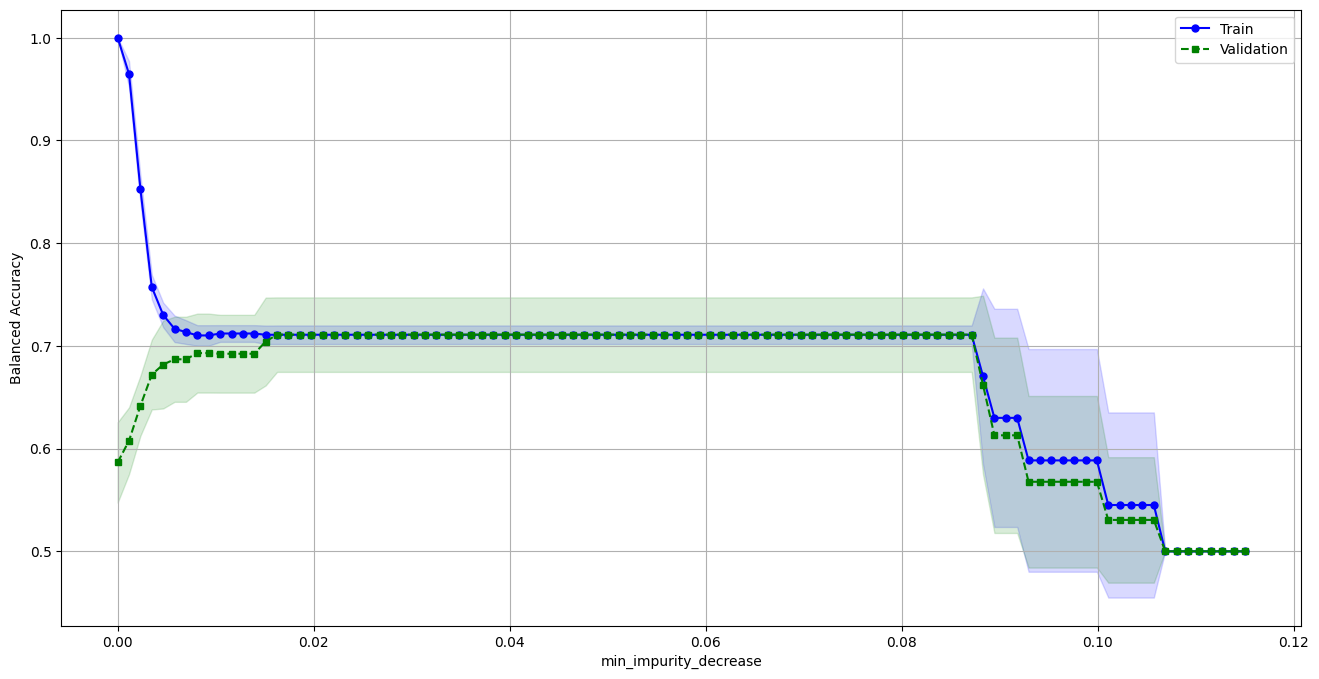

In [ ]:
train_balans = []
val_balans = []
for min_impurity_decrease in tqdm(values):
    scores = cross_validate(
        estimator=DecisionTreeClassifier(min_impurity_decrease=min_impurity_decrease, random_state=42),
        X=X_train,
        y=y_train,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        return_train_score=True,
        scoring='balanced_accuracy',
        n_jobs=-1)
    train_balans.append(scores['train_score'])
    val_balans.append(scores['test_score'])

plot_cv_res(values, np.array(train_balans), np.array(val_balans), 'min_impurity_decrease')

Можно заметить, что форма графика напоминает предыдущий с небольшими отличиями. Важно учесть, что отличный от нуля **min_impurity_decrease** ускоряет обучение модели, так как прекращает построение узлов, если даже лучшее разбиение не приводит к снижению загрязненности выше порогового. С другой стороны, **ccp_alpha** замедляет обучение модели, поскольку сначала строится все дерево, а затем обрезается по определенному критерию. Это особенно заметно при работе с большими наборами данных и создании ансамблей моделей.

Теперь мы знаем, что существуют оптимальные значения для каждого гиперпараметра. Однако это не гарантирует, что модель с комбинацией этих "оптимальных" гиперпараметров будет оптимальной. Необходимо проверить, как гиперпараметры влияют друг на друга при совместном использовании.

Существует несколько техник для решения этой задачи. Первая группа техник основана на принципе независимой проверки каждой комбинации гиперпараметров. К ним относятся методы **GridSearch** и **RandomizedSearch**.

**GridSearch** предполагает проверку всех параметров по заранее определенной сетке значений. Основной недостаток этого подхода - высокая вычислительная сложность. Например, для проверки 5 параметров с 10 возможными значениями потребуется обучить алгоритм $10^5$ раз (без учета кросс-валидации).

**RandomizedSearch** позволяет случайным образом выбирать параметры из предварительно заданных множеств столько раз, сколько мы можем себе позволить. Кроме того, **RandomizedSearch** позволяет при 15 испытаниях на три параметра проверить у каждого параметра по 15 возможных значений, в то время как **GridSearch** - только 5. Это особенно важно, когда некоторые параметры могут оказаться бесполезными.

In [ ]:
# Определим словарь `param_dist`, который содержит диапазоны значений для каждого гиперпараметра,
# и передает его в конструктор `RandomizedSearchCV`:
param_dist = {"max_depth": randint(1, 30),
              "min_samples_leaf": randint(1, 50),
              "min_samples_split": randint(2, 100),
              "max_leaf_nodes": randint(2, 1000),
              "min_impurity_decrease": uniform(0.0, 0.1)}

# Передадим экземпляр модели DecisionTreeClassifier с фиксированным состоянием случайности, чтобы результаты были воспроизводимыми
rs = RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                        param_distributions=param_dist, # передается словарь param_dist, который содержит диапазоны значений для каждого гиперпараметра
                        scoring='balanced_accuracy', # указывает, что метрика оценки будет balanced_accuracy, что означает сбалансированную точность
                        n_iter=100, #Определяет количество итераций для случайного поиска
                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), # передается объект StratifiedKFold с пятью разделениями,
                                                                                        # который будет использоваться для кросс-валидации
                        random_state=42,
                        n_jobs=-1) # указывает, что все доступные ядра процессора будут использоваться для параллельного выполнения

#Затем код обучает модель на тренировочных данных, используя признаки из столбца `arteria` и целевую переменную из столбца `target`:
rs.fit(X_train, y_train);

Количество `random_state` на квадратный сантиметр кода приобрело токсический характер. Но это необходимо для воспроизводимости исследований. И если при кросс-валидации (случайное перемешивание) и рандомизированном поиске (случайное семплирование) необходимость в фиксировании сида очевидна. То найти сходу стохастичность в построении дерева решений с параметрами по умолчанию не просто. Но на самом деле все тривиально. Если встречается несколько возможных сплитов с одинаковым значением `impurity_decrease`, то из них выбирается случайный.

### .best_params_

Посмотрим на лучшие гиперпараметры модели

Команда **.best_params_** возвращает словарь с лучшими найденными гиперпараметрами после выполнения случайного поиска в объекте **RandomizedSearchCV**. Эти параметры были выбраны на основе метрики оценки, заданной при инициализации **RandomizedSearchCV**, которая в нашем случае была **balanced_accuracy**.

In [ ]:
rs.best_params_

{'max_depth': 3,
 'max_leaf_nodes': 154,
 'min_impurity_decrease': 0.0005061583846218687,
 'min_samples_leaf': 46,
 'min_samples_split': 83}

Обучим модель на лучших параметрах

In [ ]:
model = DecisionTreeClassifier(random_state=42, **rs.best_params_)
model = model.fit(X_train, y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
train_probs = model.predict_proba(X_train)[:, 1]
test_probs = model.predict_proba(X_test)[:, 1]

In [ ]:
evaluate_model(X_train, X_test, y_train, y_test, train_preds, test_preds, train_probs, test_probs)

Метрики на тренировочной выборке:
Accuracy (достоверность): 0.7208
Balanced Accuracy (сбалансированная достоверность): 0.7233
Precision (точность): 0.7257
Recall (полнота): 0.7619
F1 score (F1-мера): 0.7210
Specificity (специфичность): 0.6847
ROC AUC: 0.7739
PR AUC: 0.6951

Метрики на тестовой выборке:
Accuracy (достоверность): 0.7277
Balanced Accuracy (сбалансированная достоверность): 0.7279
Precision (точность): 0.7289
Recall (полнота): 0.7303
F1 score (F1-мера): 0.7280
Specificity (специфичность): 0.7255
ROC AUC: 0.8076
PR AUC: 0.7361



Результаты модели стали лучше, но не обогнали результаты логистической регрессии.

## Важности признаков для дерева

Создадим функцию, которая упорядочивает и визуализирует информацию о том, как уменьшается нечистота (**impurity**) для каждого признака.

**Нечистота** - это мера неопределенности в классификационной модели, которая уменьшается по мере добавления новых признаков. Метод нормализует эту информацию, чтобы сравнить влияние разных признаков на уменьшение нечистоты, и затем визуализирует её, чтобы сделать выводы о важности каждого признака

In [ ]:
def plot_imp(arteria, influence):
    order = np.argsort(influence) # создает индексы для сортировки признаков по убыванию их важности
    arteria = arteria[order] # сортирует названия признаков в соответствии с их относительной важностью
    influence = influence[order] # сортирует вектор важности признаков в соответствии с их относительной важностью
    for idx, val in enumerate(influence): # перебирает индексы и значения важности признаков
        print(f'{arteria[idx]:40} {val:.10f}') # выводит на экран названия признаков и их относительные значения важности, округляя до 4-х знаков после запятой
    plt.figure(figsize=(4, np.ceil(len(arteria) / 4))) # создает график с размерами, которые зависят от количества анализируемых признаков
    plt.barh(arteria, influence) # рисует гистограмму, где высота столбцов соответствует названиям признаков, а ширина - их относительным значениям важности
    plt.show() # отображает график на экране

Пол                                      0.0000000000
Национальность_Белорусы                  0.0000000000
Национальность_Буряты                    0.0000000000
Национальность_Другие национальности     0.0000000000
Национальность_Евреи                     0.0000000000
Национальность_Казахи                    0.0000000000
Национальность_Киргизы                   0.0000000000
Национальность_Молдаване                 0.0000000000
Национальность_Мордва                    0.0000000000
Национальность_Немцы                     0.0000000000
Национальность_Русские                   0.0000000000
Национальность_Таджики                   0.0000000000
Национальность_Татары                    0.0000000000
Национальность_Украинцы                  0.0000000000
Национальность_Чуваши                    0.0000000000
Алкоголь_ранее употреблял                0.0000000000
Национальность_Эстонцы                   0.0000000000
Религия_Ислам                            0.0000000000
Религия_Нет                 

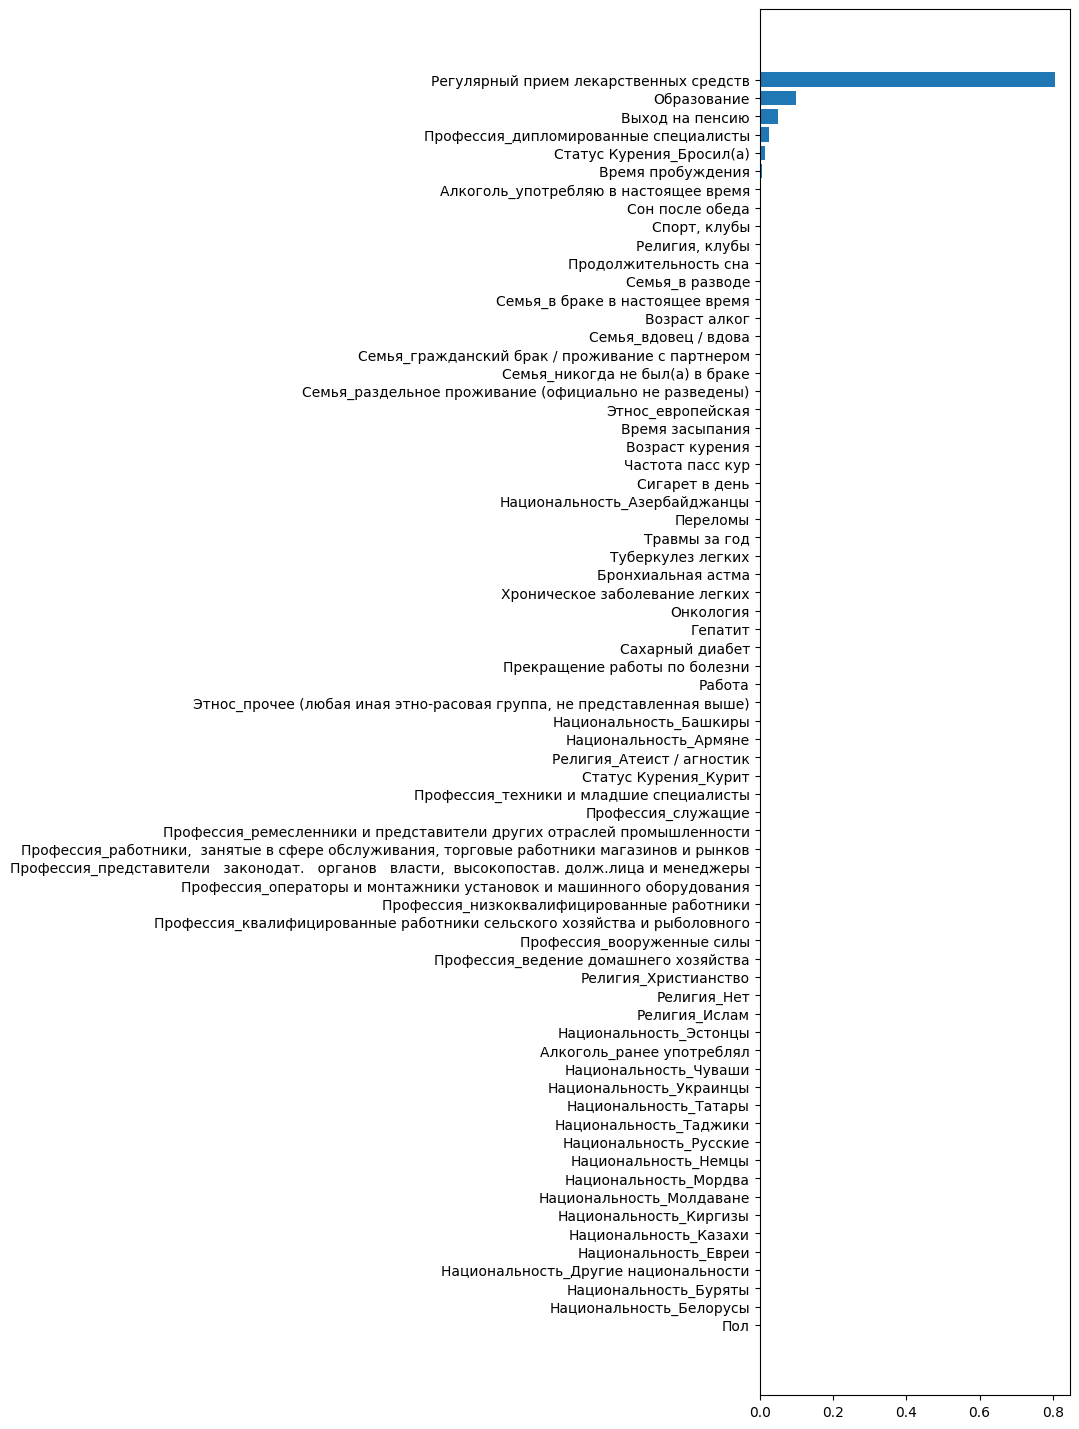

In [ ]:
plot_imp(arteria, model.feature_importances_)

Признаки, наиболее влияющие на артериальную гипертензию:
* **Регулярный прием лекарственных средств**
* Образование  
* Выход на пенсию
* Профессия_дипломи рованные специалисты
* Статус Курения_Бросил(а)
* Время пробуждения      
      



---



## Random Forest

Дерево решений часто оказывается склонным к переобучению, что делает его менее популярным в качестве отдельного алгоритма. Однако оно находит широкое применение в ансамблях. Например, в методе случайного леса, где стремятся к созданию разнообразных деревьев с различными ответами, которые затем усредняются для получения более надежного прогноза. Вместе они образуют мощный инструмент для решения сложных задач классификации и регрессии.

### Список параметров класса **RandomForestClassifier** из библиотеки **Scikit-Learn**:

**Параметры:**

- **n_estimators**: количество деревьев в ансамбле (по умолчанию равно 10)
- **criterion**: критерий, используемый для определения наилучшего разделения на каждом этапе. Доступные варианты: `"gini"` и `"entropy"` (по умолчанию равен `"gini"`).
- **max_depth**: максимальная глубина каждого дерева в ансамбле. Если `None`, то деревья не имеют ограничений по глубине
- **min_samples_split**: минимальное количество наблюдений, необходимых для разделения узла
- **min_samples_leaf**: минимальное количество наблюдений в листе (терминальном узле) дерева
- **min_weight_fraction_leaf**: аналогичен `min_samples_leaf`, но выражен в терминах минимальной доли весов наблюдений, а не абсолютного числа наблюдений
- **max_features**: количество признаков, рассматриваемых при выборе лучшего разделения. Доступные варианты: `"auto"`, `"sqrt"`, `"log2"`, `"none"` (по умолчанию равен `"auto"`)
- **max_leaf_nodes**: максимальное количество листьев в дереве. Если `None`, то количество листьев не ограничено
- **min_impurity_decrease**: минимальное снижение нечистоты, требуемое для дальнейшего разделения узла
- **bootstrap**: использовать ли выборку с замещением при обучении деревьев (по умолчанию `True`)
- **oob_score**: вычислять оценку вне выборки (out-of-bag score) при обучении
- **n_jobs**: количество ядер процессора, которые будут использоваться для параллельного выполнения (по умолчанию равномерно распределяется между всеми доступными ядрами)
- **random_state**: случайное состояние, используемое для обеспечения воспроизводимости
- **verbose**: уровень детализации вывода
- **warm_start**: использовать ли "теплый старт" для продолжения обучения с предыдущим ансамблем деревьев
- **class_weight**: вектор или функция, определяющая вес каждого класса
- **ccp_alpha**: параметр регуляризации, используемый для обрезания дерева.
- **max_samples**: максимальное количество наблюдений, используемых при обучении одного дерева. Если `None`, используется весь набор данных

In [ ]:
model = RandomForestClassifier(random_state=42, n_jobs=-1)
model= model.fit(X_train, y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
train_probs = model.predict_proba(X_train)[:, 1]
test_probs = model.predict_proba(X_test)[:, 1]

In [ ]:
evaluate_model(X_train, X_test, y_train, y_test, train_preds, test_preds, train_probs, test_probs)

Метрики на тренировочной выборке:
Accuracy (достоверность): 1.0000
Balanced Accuracy (сбалансированная достоверность): 1.0000
Precision (точность): 1.0000
Recall (полнота): 1.0000
F1 score (F1-мера): 1.0000
Specificity (специфичность): 1.0000
ROC AUC: 1.0000
PR AUC: 1.0000

Метрики на тестовой выборке:
Accuracy (достоверность): 0.7382
Balanced Accuracy (сбалансированная достоверность): 0.7370
Precision (точность): 0.7382
Recall (полнота): 0.7191
F1 score (F1-мера): 0.7382
Specificity (специфичность): 0.7549
ROC AUC: 0.8013
PR AUC: 0.7483



Случайный лес, как и дерево решений, полностью запомнил данные обучающей выборки. Однако, даже без подбора гиперпараметров, случайный лес показывает более высокую эффективность на тестовой выборке по сравнению с отдельным деревом.

Дополнительным преимуществом метода случайного леса является возможность проведения валидации на объектах, не вошедших в обучающую выборку (**out-of-bag, OOB**). Суть данной методики заключается в том, что каждое дерево строится на подмножестве данных, и часть объектов оказывается не использованной при обучении данного дерева. Таким образом, эти недоиспользованные объекты могут быть использованы для оценки качества модели без необходимости отдельной валидационной выборки, что увеличивает эффективность и устойчивость модели случайного леса.


**Optuna** — это фреймворк для автоматического поиска гиперпараметров, который поддерживает Python. Он помогает разработчикам машинного обучения оптимизировать свои модели, позволяя им задавать ограничения и цели для своих экспериментов.

**Optuna** использует адаптивный алгоритм, который постепенно улучшает поиск, изучая поведение функции потерь. Это позволяет ему находить оптимальные значения гиперпараметров быстрее, чем традиционные методы.

Одной из ключевых особенностей **Optuna** является его способность работать с различными типами функций потерь, включая сложные функции потерь, которые могут быть определены пользователем. Это делает его идеальным инструментом для оптимизации сложных моделей машинного обучения.

Кроме того, **Optuna** предоставляет мощные инструменты для управления экспериментами, такие как визуализация результатов и возможность сохранения и восстановления состояния эксперимента. Это позволяет разработчикам легко отслеживать прогресс и повторять успешные эксперименты.


In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.7 MB/s eta 0:00:00


In [ ]:
import optuna  # импорт библиотеки Optuna, которая используется для оптимизации гиперпараметров
from optuna.samplers import RandomSampler # импорт класса RandomSampler из модуля optuna.samplers,
                                          # который будет использоваться для случайного выбора гиперпараметров

def objective(trial): # определяет функцию objective, которая будет использоваться Optuna для оптимизации
                      # Эта функция принимает аргумент `trial`, который представляет текущую попытку оптимизации

# Используем метод suggest_int для выбора целого числа в диапазоне от 1 до 10 для гиперпараметра min_samples_leaf.
# Аналогично для других параметров
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    max_depth = trial.suggest_int("max_depth", 1, 25)
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 2, 1000, step=1)
# Используем suggest_discrete_uniform для выбора дискретного значения для min_impurity_decrease в диапазоне от 0 до 0.1 с шагом 0.0001
    min_impurity_decrease = trial.suggest_discrete_uniform('min_impurity_decrease', 0., 0.1, 0.0001)
# Вычисляем длину массива arteria, который содержит признаки
    n_arteria = len(arteria)

    max_features = trial.suggest_int("max_features", 1, n_arteria)
    max_samples = trial.suggest_discrete_uniform('max_samples', 0.1, 1., 0.1)
# Создаем экземпляр класса RandomForestClassifier с выбранными гиперпараметрами
    rf = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True,
                                max_depth=max_depth,
                                min_samples_leaf=min_samples_leaf,
                                min_samples_split=min_samples_split,
                                max_leaf_nodes=max_leaf_nodes,
                                min_impurity_decrease=min_impurity_decrease,
                                max_samples=max_samples,
                                max_features=max_features,
                                )
# Обучаем модель на тренировочных данных
    rf.fit(X_train, y_train)
# Возвращаем значение балансированной точности, которое будет использоваться Optuna для оптимизации
# из матрицы `oob_decision_function_`, которая содержит результаты классификации вне выборки (out-of-bag) для каждого наблюдения,
# выбираются только те значения, которые находятся в первом столбце (так как первый столбец обычно содержит значения для класса 1),
# и проверяется, превышают ли они пороговое значение 0.5. Это используется для определения, был ли класс 1 правильно предсказан или нет.
    return balanced_accuracy_score(y_train, rf.oob_decision_function_[:, 1] > 0.5)

# Создаем новый объект исследования с направлением оптимизации на максимизацию и именем "RF", используя RandomSampler
# с фиксированным состоянием случайности
study = optuna.create_study(direction="maximize", study_name="RF", sampler=RandomSampler(42))
# Запускаем оптимизацию, вызывая метода optimize объекта исследования с функцией objective и количеством итераций n_trials=100
study.optimize(objective, n_trials=100)

[I 2024-10-29 14:25:13,720] A new study created in memory with name: RF
[I 2024-10-29 14:25:14,012] Trial 0 finished with value: 0.7019462957596831 and parameters: {'min_samples_leaf': 4, 'min_samples_split': 20, 'max_depth': 19, 'max_leaf_nodes': 600, 'min_impurity_decrease': 0.015600000000000001, 'max_features': 11, 'max_samples': 0.1}. Best is trial 0 with value: 0.7019462957596831.
[I 2024-10-29 14:25:14,287] Trial 1 finished with value: 0.7107601661354197 and parameters: {'min_samples_leaf': 9, 'min_samples_split': 13, 'max_depth': 18, 'max_leaf_nodes': 22, 'min_impurity_decrease': 0.097, 'max_features': 58, 'max_samples': 0.30000000000000004}. Best is trial 1 with value: 0.7107601661354197.
[I 2024-10-29 14:25:14,705] Trial 2 finished with value: 0.6922631121414082 and parameters: {'min_samples_leaf': 2, 'min_samples_split': 5, 'max_depth': 8, 'max_leaf_nodes': 526, 'min_impurity_decrease': 0.0432, 'max_features': 21, 'max_samples': 0.7000000000000001}. Best is trial 1 with value

In [ ]:
# Выведем словарь с лучшими найденными гиперпараметрами:
study.best_params

{'min_samples_leaf': 5,
 'min_samples_split': 9,
 'max_depth': 16,
 'max_leaf_nodes': 636,
 'min_impurity_decrease': 0.0045000000000000005,
 'max_features': 26,
 'max_samples': 0.7000000000000001}

In [ ]:
# Построим график параллельных координат для визуализации влияния различных гиперпараметров на результат оптимизации
# График поможет понять, как изменение каждого гиперпараметра влияет на общую производительность модели
optuna.visualization.plot_parallel_coordinate(study)

Существуют и другие важные гиперпараметры, которые мы пока не обсуждали. Один из них - это количество деревьев в ансамбле. Обычно его значение выбирается интуитивно (чем больше, тем лучше) и не требует оптимизации. Тем не менее, в некоторых случаях увеличение числа деревьев может потребовать уменьшения значений **max_samples** и **max_features**.


100%|██████████| 100/100 [02:25<00:00,  1.46s/it]


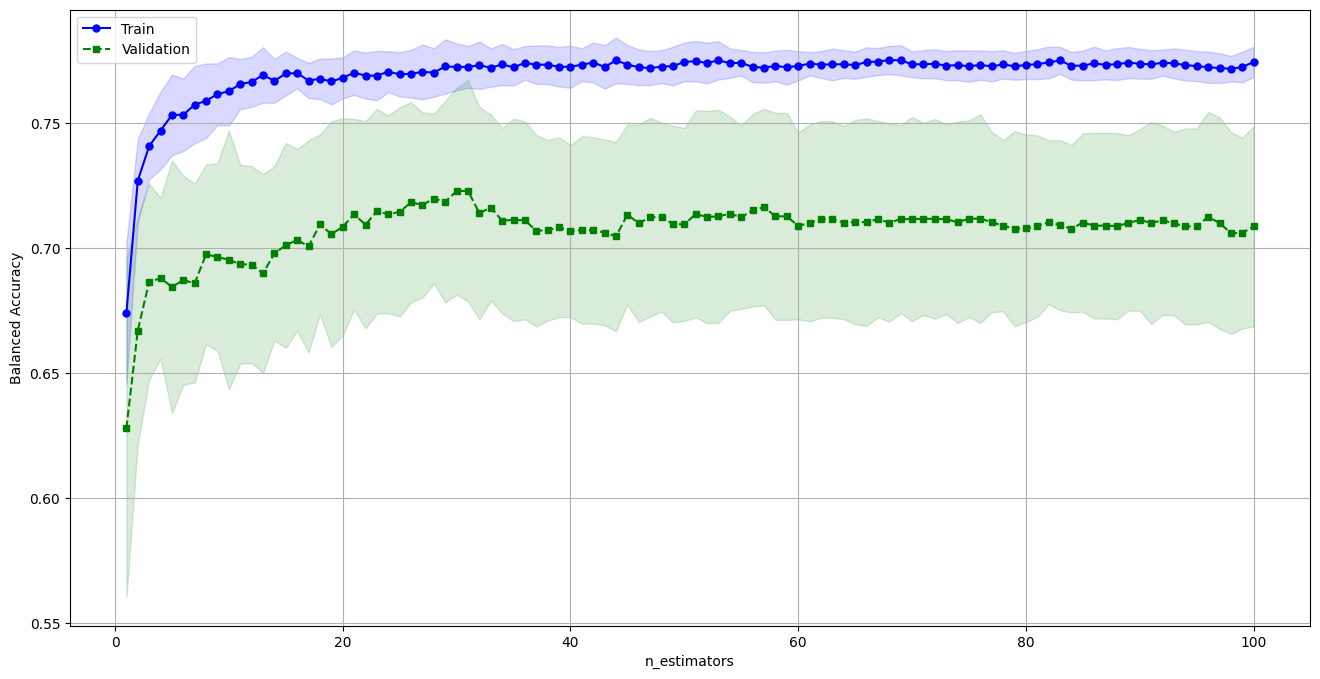

In [ ]:
train_balans = []
val_balans = []
values = list(range(1, 101))

for n_estimators in tqdm(values):
# Выполняем кросс-валидацию с использованием модели `RandomForestClassifier` с лучшими найденными гиперпараметрами (`**study.best_params`)
# и количеством деревьев `n_estimators`, которое меняется на каждой итерации.
    scores = cross_validate(
        estimator=RandomForestClassifier(n_estimators=n_estimators, random_state=42, **study.best_params),
        X=X_train,
        y=y_train,
        cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
        return_train_score=True,
        scoring='balanced_accuracy',
        n_jobs=-1)

# Добавляем оценки на тренировочном наборе данных в список `train_balans`,
# оценки на валидационном наборе данных в список `val_balans`
    train_balans.append(scores['train_score'])
    val_balans.append(scores['test_score'])

# Вызываем функцию `plot_cv_res` для визуализации результатов кросс-валидации, передавая ей списки значений `n_estimators`,
# оценок на тренировочном и валидационном наборах данных, а также метку для оси `x`
plot_cv_res(values, np.array(train_balans), np.array(val_balans), 'n_estimators')

In [ ]:
# Создаем экземпляр класса `RandomForestClassifier` с фиксированным состоянием случайности, используя все лучшие найденные гиперпараметры
# из `study.best_params`, а также устанавливаем количество деревьев в ансамбле `n_estimators` равным 10000 и используем все доступные ядра
# процессора для параллельного выполнения
model= RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=10000, **study.best_params)

model = model.fit(X_train, y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
train_probs = model.predict_proba(X_train)[:, 1]
test_probs = model.predict_proba(X_test)[:, 1]

evaluate_model(X_train, X_test, y_train, y_test, train_preds, test_preds, train_probs, test_probs)

Метрики на тренировочной выборке:
Accuracy (достоверность): 0.7654
Balanced Accuracy (сбалансированная достоверность): 0.7681
Precision (точность): 0.7705
Recall (полнота): 0.8095
F1 score (F1-мера): 0.7655
Specificity (специфичность): 0.7266
ROC AUC: 0.8492
PR AUC: 0.8341

Метрики на тестовой выборке:
Accuracy (достоверность): 0.7696
Balanced Accuracy (сбалансированная достоверность): 0.7721
Precision (точность): 0.7742
Recall (полнота): 0.8090
F1 score (F1-мера): 0.7698
Specificity (специфичность): 0.7353
ROC AUC: 0.8273
PR AUC: 0.7755



Важности у случайного леса можно посмотреть, как суммы важностей этих признаков в каждом дереве.
Следующий код создает график, который показывает относительную важность признаков для модели машинного обучения.

`influence` - это вектор, содержащий относительные значения важности для каждого признака.

`plot_imp` - это функция важности признаков, которую мы создали ранее  

Национальность_Башкиры                   0.0000000000
Национальность_Таджики                   0.0000000000
Национальность_Чуваши                    0.0000000000
Национальность_Эстонцы                   0.0000000000
Семья_раздельное проживание (официально не разведены) 0.0000000000
Этнос_прочее (любая иная этно-расовая группа, не представленная выше) 0.0000000000
Профессия_вооруженные силы               0.0000000000
Национальность_Азербайджанцы             0.0000000000
Национальность_Немцы                     0.0000000000
Национальность_Украинцы                  0.0000000000
Национальность_Белорусы                  0.0000000000
Национальность_Буряты                    0.0000000000
Национальность_Другие национальности     0.0000000000
Национальность_Евреи                     0.0000000000
Национальность_Казахи                    0.0000000000
Национальность_Киргизы                   0.0000000000
Национальность_Молдаване                 0.0000000000
Национальность_Мордва                   

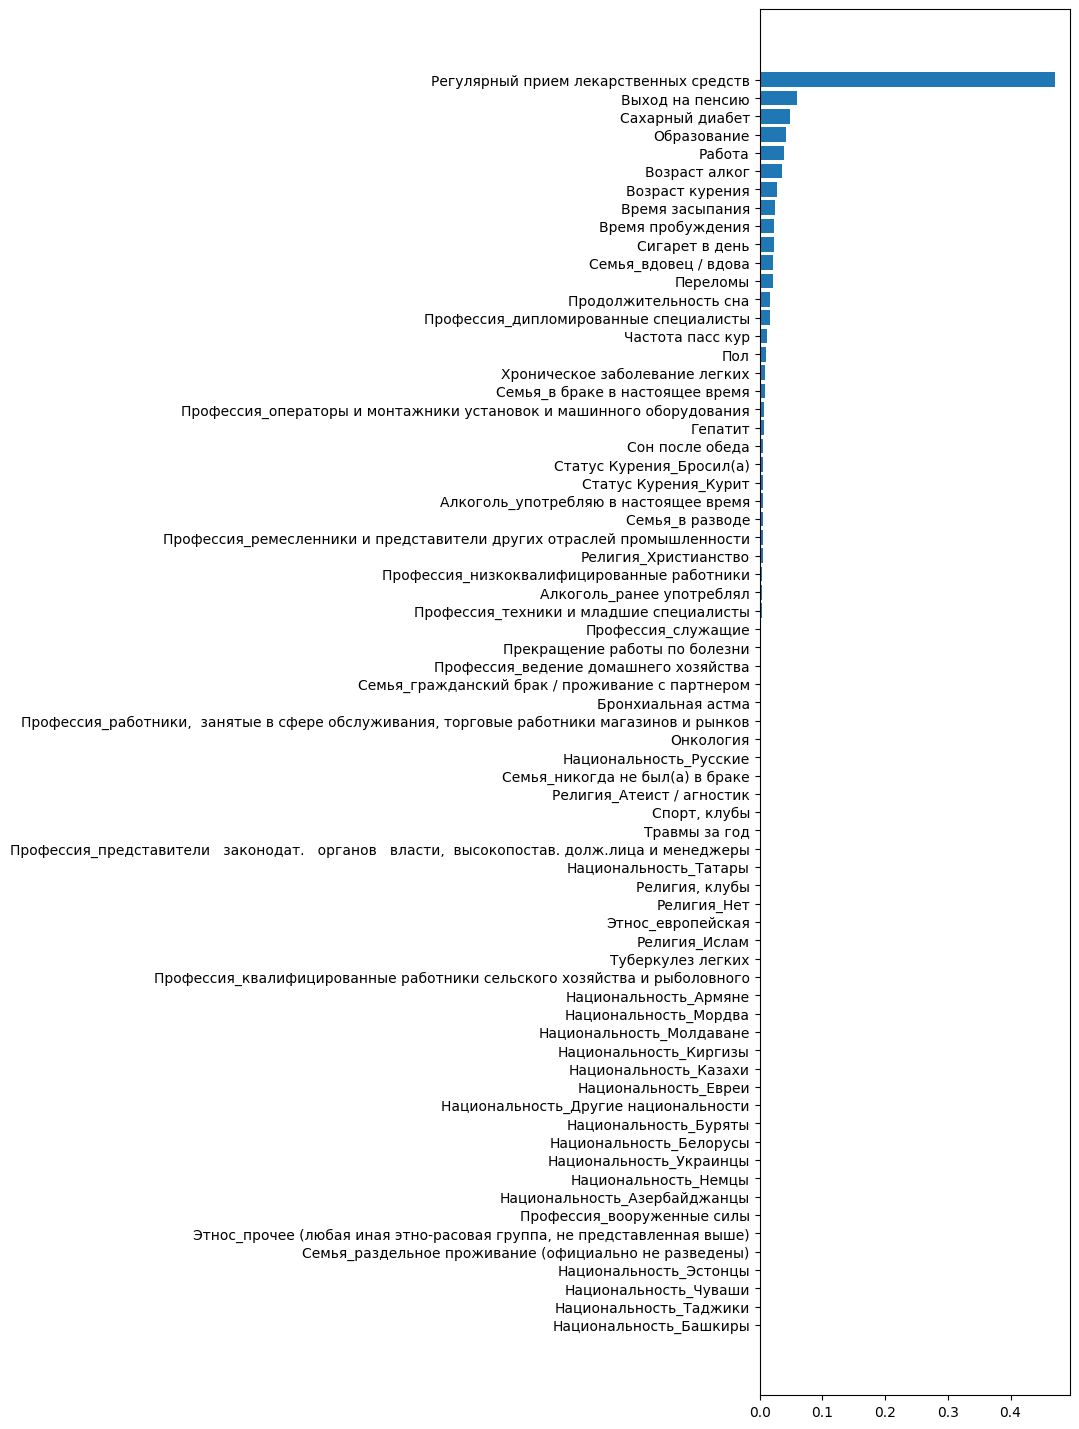

In [ ]:
influence = model.feature_importances_
plot_imp(arteria, influence)

Признаки, наиболее влияющие на артериальную гипертензию:
* Регулярный прием лекарственных средств
* Выход на пенсию
* Сахарный диабет
* Образование  
* Работа
* Возраст алког
* Возраст курения

## Перестановочные важности

Часто более предпочтительный подход - это использование перестановочных важностей. В этом методе исследуется влияние каждого признака на ошибку модели. Для этого каждый признак рандомно перемешивается.

Функция **permutation_importance** из модуля **sklearn.inspection** используется для оценки важности признаков путем их случайного перемешивания.


Она работает путем случайной перестановки значений каждого признака и измерения влияния этой перестановки на точность модели.

Аргументы функции permutation_importance включают:
* **estimator**: экземпляр модели, которую нужно оценить
* **X**: матрица входных данных
* **y**: вектор целевых переменных
* **scoring**: функция оценки качества модели
* **n_repeats**: количество повторов для каждой перестановки
* **n_jobs**: количество ядер процессора, которое можно использовать для параллельной обработки
* **random_state**: случайное состояние, используемое для воспроизводимости результатов
* **sample_weight**: веса наблюдений, которые могут быть использованы для взвешивания данных

После выполнения функции **permutation_importance** возвращается словарь, содержащий информацию о важности каждого признака, включая среднее изменение оценки качества модели и стандартное отклонение этого изменения.

In [ ]:
# Вызываем функцию permutation_importance, передавая ей модель model, признаки из тестового набора данных X_test,
# целевую переменную тестового набора данных y_test, количество повторений n_repeats, фиксированное состояние случайности random_state,
# метрику оценки scoring и параметр n_jobs для использования всех доступных ядер процессора
perm_imp_test = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42,
                                       scoring='balanced_accuracy', n_jobs=-1)
perm_imp_train = permutation_importance(model, X_train, y_train, n_repeats=5, random_state=42,
                                        scoring='balanced_accuracy', n_jobs=-1)
# Получаем индексы, которые упорядочивают признаки по убыванию среднего значения важности, полученного в результате перестановок
perm_sorted_idx = perm_imp_test.importances_mean.argsort()

In [ ]:
# Вывод индексов признаков в порядке увеличения их важности
print("Индексы признаков по возрастанию их важности:", perm_sorted_idx)

Индексы признаков по возрастанию их важности: [19 14 66  8 15 24 59 58 61 16  6 53 50 18 62 42 43  0 45 39 38 37 41 40
 51 48 49 36 52 54 55 57 65 47 35 34 33 32 31 30 29 10 27 12 21  4 22 67
 46  9 63 28 17 25 20 23 64 26 68  7  3  2  5 60 13 56 44  1 11]


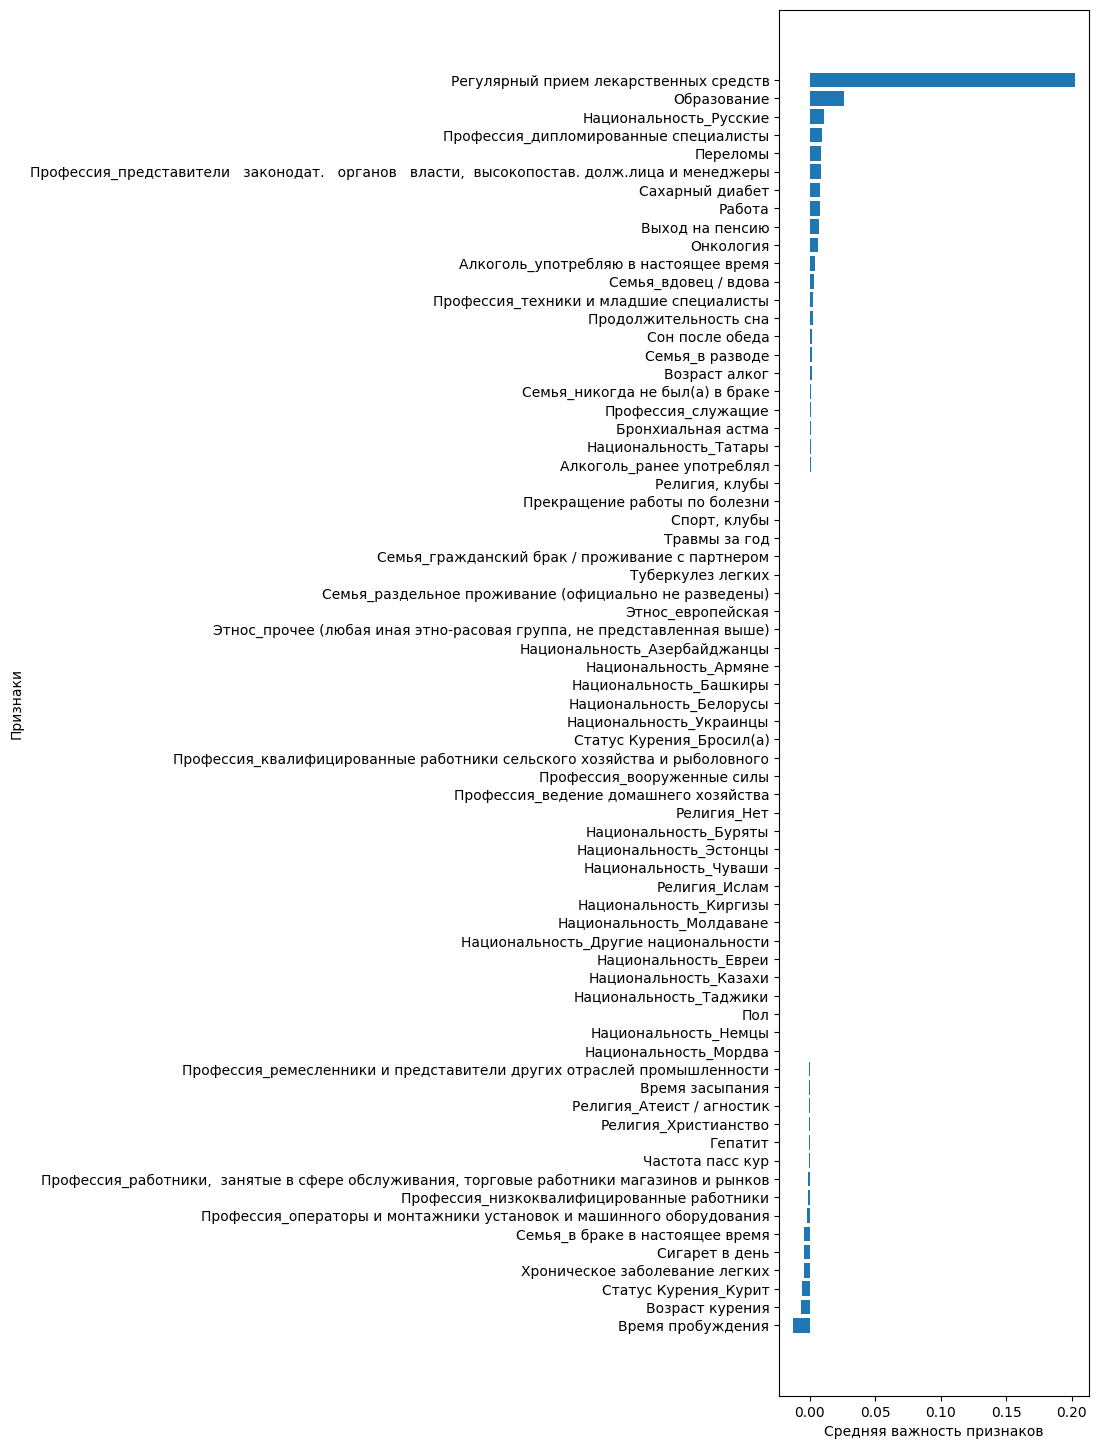

In [ ]:
# Визуализация важности признаков
plt.figure(figsize=(4, np.ceil(len(arteria) / 4)))
plt.barh(range(X_test.shape[1]), perm_imp_test.importances_mean[perm_sorted_idx])
plt.xlabel("Средняя важность признаков")
plt.ylabel("Признаки")
plt.yticks(range(X_test.shape[1]), [arteria[i] for i in perm_sorted_idx])
plt.show()

In [ ]:
# Вывод имен признаков в порядке возрастания их важности
print("Порядок признаков по важности:")
for i in perm_sorted_idx:
    print(f"{arteria[i]}: {perm_imp_test.importances_mean[i]:.4f}")

Порядок признаков по важности:
Время пробуждения: -0.0125
Возраст курения: -0.0065
Статус Курения_Курит: -0.0062
Хроническое заболевание легких: -0.0046
Сигарет в день: -0.0041
Семья_в браке в настоящее время: -0.0039
Профессия_операторы и монтажники установок и машинного оборудования: -0.0022
Профессия_низкоквалифицированные работники: -0.0013
Профессия_работники,  занятые в сфере обслуживания, торговые работники магазинов и рынков: -0.0010
Частота пасс кур: -0.0009
Гепатит: -0.0007
Религия_Христианство: -0.0003
Религия_Атеист / агностик: -0.0003
Время засыпания: -0.0002
Профессия_ремесленники и представители других отраслей промышленности: -0.0001
Национальность_Мордва: 0.0000
Национальность_Немцы: 0.0000
Пол: 0.0000
Национальность_Таджики: 0.0000
Национальность_Казахи: 0.0000
Национальность_Евреи: 0.0000
Национальность_Другие национальности: 0.0000
Национальность_Молдаване: 0.0000
Национальность_Киргизы: 0.0000
Религия_Ислам: 0.0000
Национальность_Чуваши: 0.0000
Национальность_Эстон

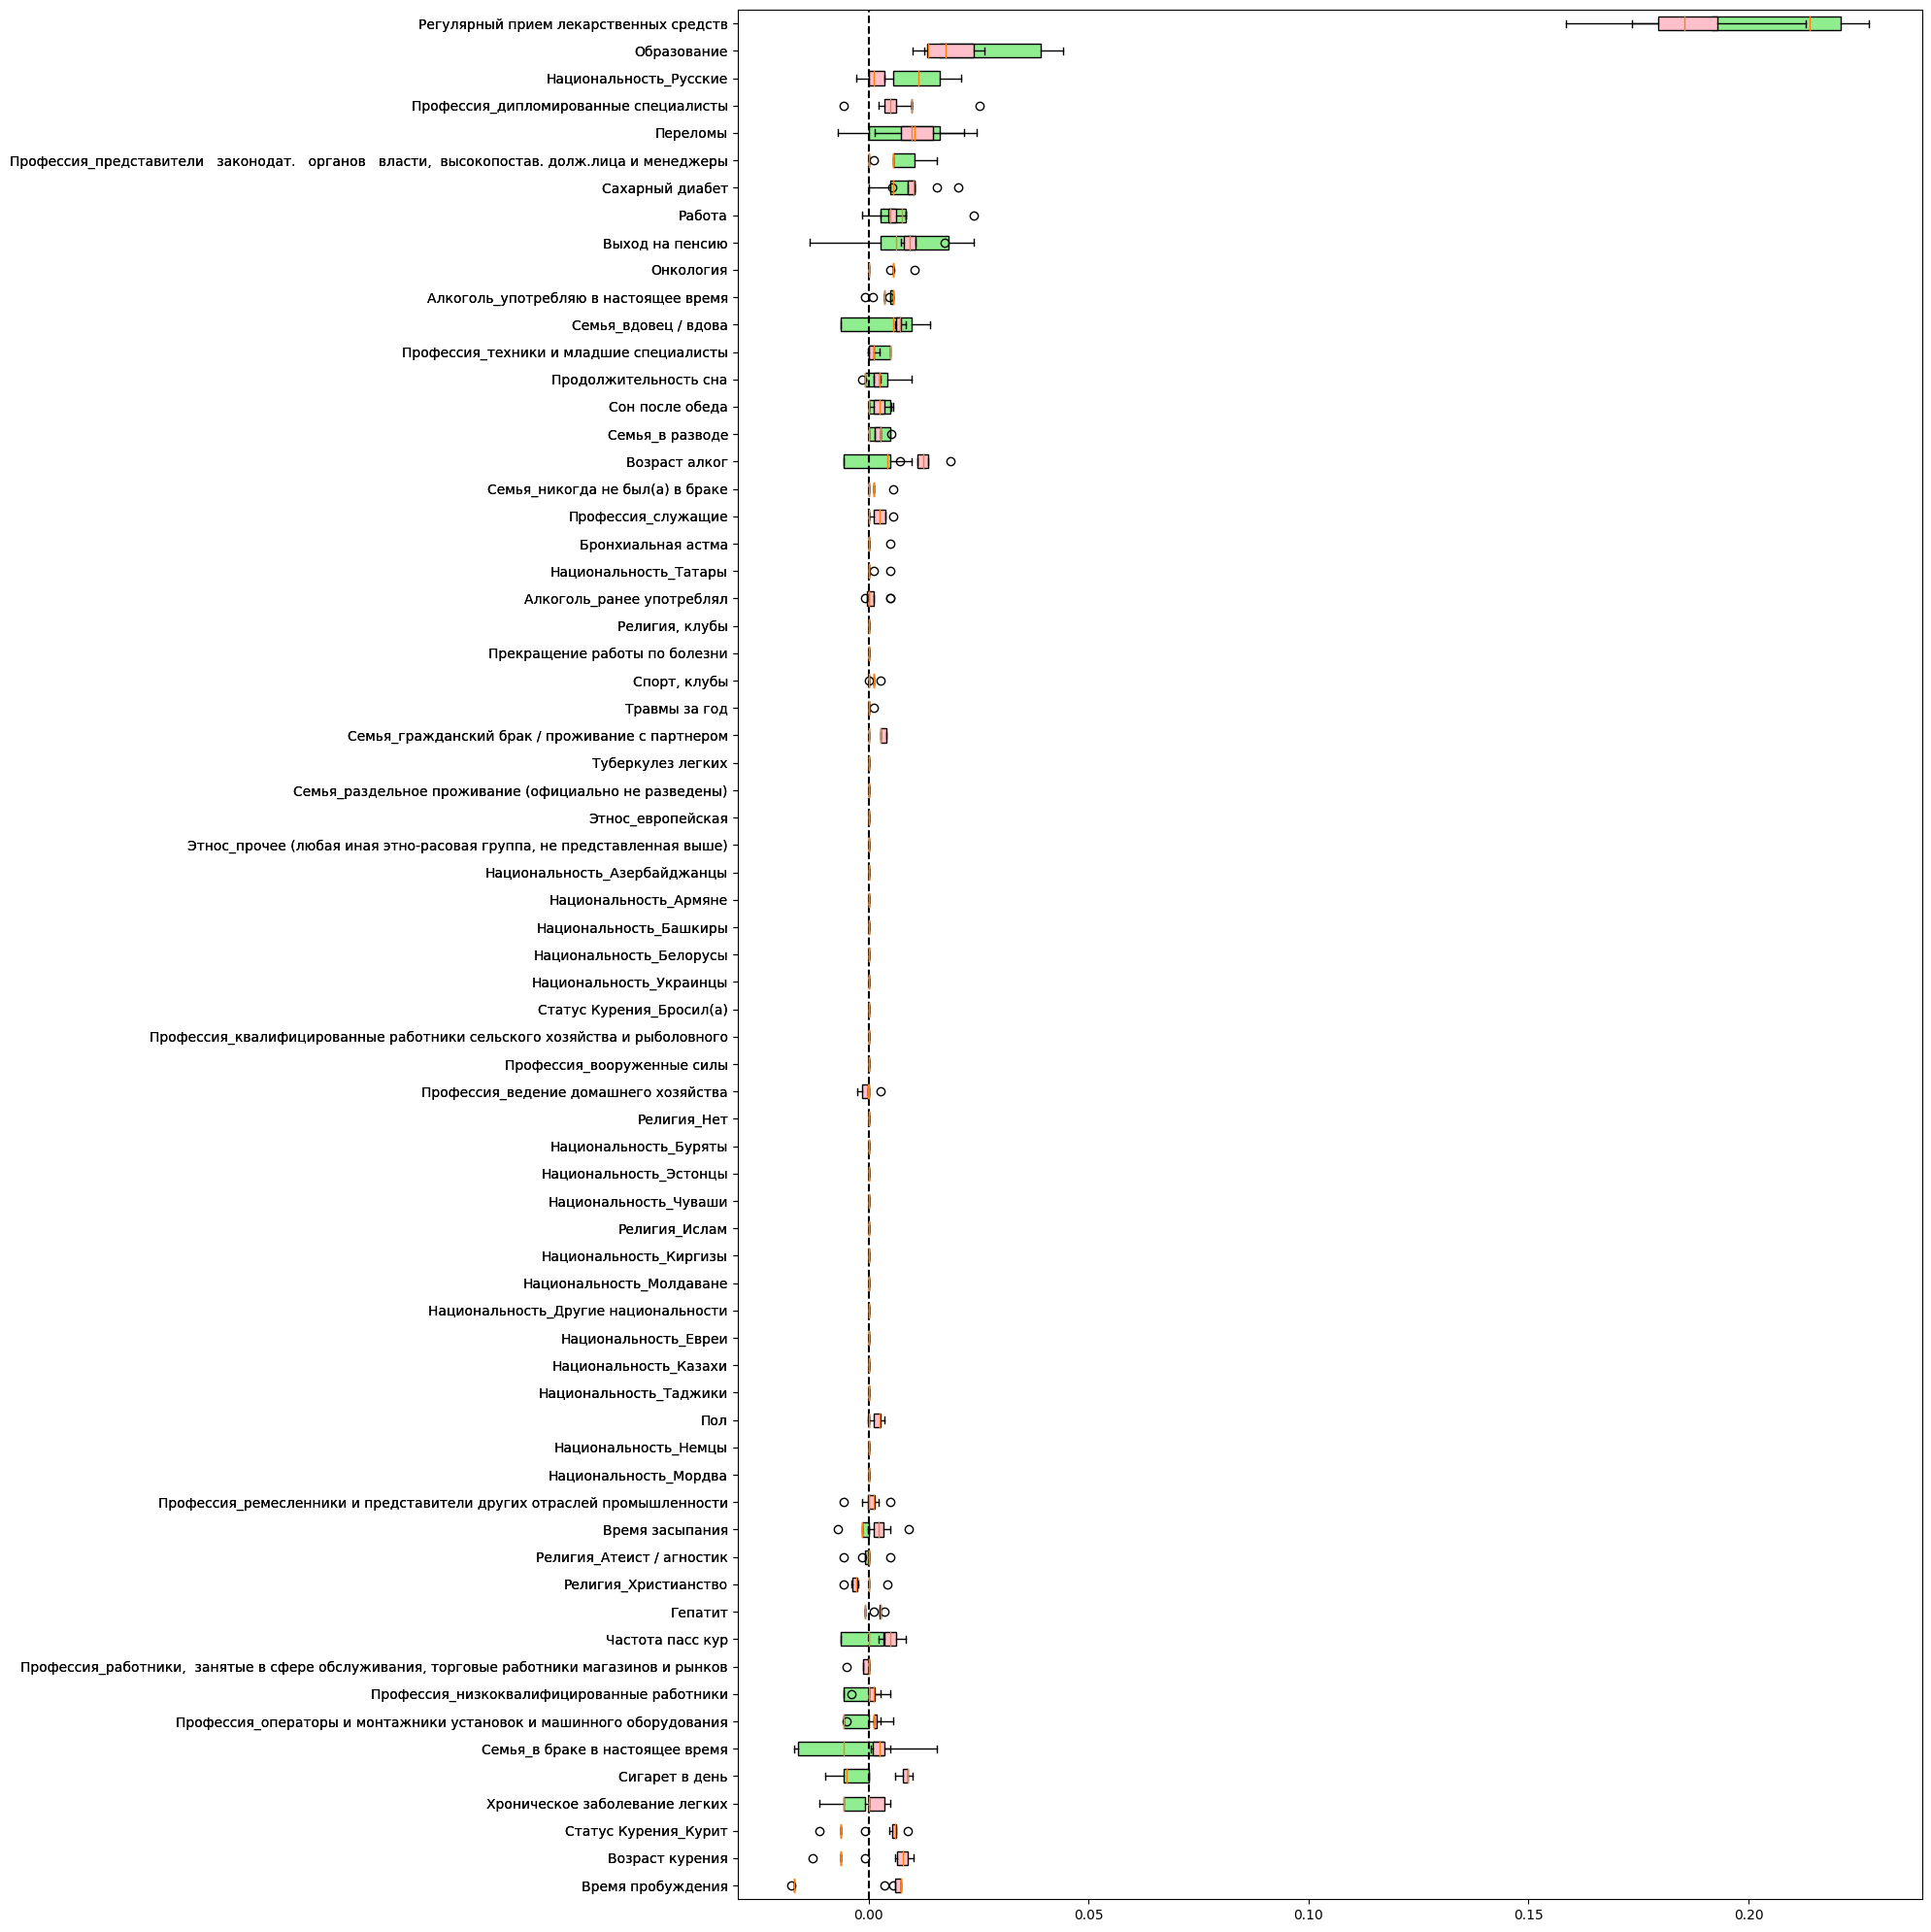

In [ ]:
plt.figure(figsize=(20, 20))
# Рисуем боксплот для тестового набора данных, используя транспонированные данные importances из perm_imp_test,
# устанавливаем vert=False для горизонтального расположения боксов, включаем patch_artist=True для настройки внешнего вида боксов
# и присваиваем метки столбцам данных из train[arteria] для соответствующих индексов в perm_sorted_idx.
bplot_te = plt.boxplot(perm_imp_test.importances[perm_sorted_idx].T,
                       vert=False, patch_artist=True,
                       labels=X_train.columns[perm_sorted_idx])

# Аналогично рисуем боксплот для тренировочного набора данных
bplot_tr = plt.boxplot(perm_imp_train.importances[perm_sorted_idx].T,
                       vert=False, patch_artist=True,
                       labels=X_train.columns[perm_sorted_idx])

for patch in bplot_tr['boxes']: # Проходимся по всем боксам в боксплоте для тренировочного набора данных
    patch.set_facecolor('pink') # Устанавливаем цвет боксов для тренировочного боксплота на розовый
for patch in bplot_te['boxes']:
    patch.set_facecolor('lightgreen')
plt.axvline(x=0, color="k", linestyle="--") # Рисуем вертикальную линию в начале координат для визуального ориентира
plt.tight_layout() # Уменьшаем пробелы между элементами графика
plt.show()

### Борьба с дисбалансом классов

**Дисбаланс классов** в машинном обучении относится к ситуации, когда в обучающем наборе данных представлены объекты из разных классов в сильно неравномерных пропорциях. Это может привести к проблемам при обучении модели, так как она может переобучиться на доминирующем классе и не справиться с распознаванием объектов из менее представленных классов.

Существует очень много способов борьбы с дисбалансом классов. Многие из них сложны и далеко не всегда эффективны. При этом есть несколько очень простых трюков, которые помогают улучшить качество работы модели при минимуме усилий.

In [ ]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=1000, oob_score=True)
model= model.fit(X_train, y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
train_probs = model.predict_proba(X_train)[:, 1]
test_probs = model.predict_proba(X_test)[:, 1]

In [ ]:
evaluate_model(X_train, X_test, y_train, y_test, train_preds, test_preds, train_probs, test_probs)

Метрики на тренировочной выборке:
Accuracy (достоверность): 1.0000
Balanced Accuracy (сбалансированная достоверность): 1.0000
Precision (точность): 1.0000
Recall (полнота): 1.0000
F1 score (F1-мера): 1.0000
Specificity (специфичность): 1.0000
ROC AUC: 1.0000
PR AUC: 1.0000

Метрики на тестовой выборке:
Accuracy (достоверность): 0.7435
Balanced Accuracy (сбалансированная достоверность): 0.7426
Precision (точность): 0.7437
Recall (полнота): 0.7303
F1 score (F1-мера): 0.7435
Specificity (специфичность): 0.7549
ROC AUC: 0.8020
PR AUC: 0.7608



In [ ]:
print(f'Balanced Accuracy on oob   {balanced_accuracy_score(y_train, model.oob_decision_function_[:, 1] >= 0.5):.5f}')

Balanced Accuracy on oob   0.71153


### Методы борьбы с дисбалансом классов:

1. Изменение "веса" объектов разного класса.

В sklearn чтобы модель учла дисбаланс классов можно указать гиперпараметр `class_weight='balanced'`

In [ ]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=1000, oob_score=True,
                                    class_weight='balanced')
model= model.fit(X_train, y_train)
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
train_probs = model.predict_proba(X_train)[:, 1]
test_probs = model.predict_proba(X_test)[:, 1]

In [ ]:
evaluate_model(X_train, X_test, y_train, y_test, train_preds, test_preds, train_probs, test_probs)

Метрики на тренировочной выборке:
Accuracy (достоверность): 1.0000
Balanced Accuracy (сбалансированная достоверность): 1.0000
Precision (точность): 1.0000
Recall (полнота): 1.0000
F1 score (F1-мера): 1.0000
Specificity (специфичность): 1.0000
ROC AUC: 1.0000
PR AUC: 1.0000

Метрики на тестовой выборке:
Accuracy (достоверность): 0.7382
Balanced Accuracy (сбалансированная достоверность): 0.7370
Precision (точность): 0.7382
Recall (полнота): 0.7191
F1 score (F1-мера): 0.7382
Specificity (специфичность): 0.7549
ROC AUC: 0.7951
PR AUC: 0.7502



2. Изменение порога бинаризации ответов модели

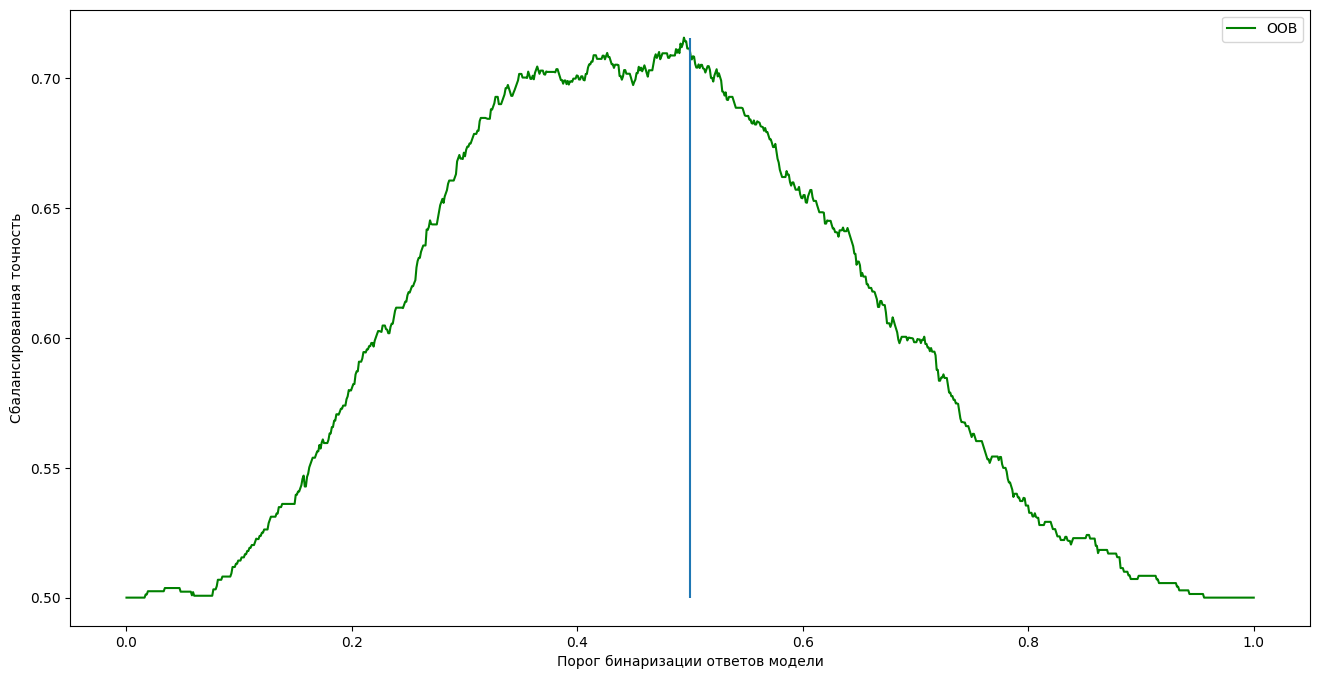

In [ ]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=1000, oob_score=True)
model= model.fit(X_train, y_train)
# Сохраняет прогнозы, полученные вне выборки (OOB), в переменную `oob_preds`
oob_preds = model.oob_decision_function_[:, 1]
# Создает пустой список `oob_balans`, который будет использоваться для хранения балансированных точности для различных пороговых значений
oob_balans = []
# Создает массив значений от 0 до 1 с шагом 0.001, который будет использоваться для итераций по пороговым значениям
values = np.linspace(0, 1, 1000)
# Для каждого порогового значения в массиве `values` вычисляет cбалансированную точность, сравнивая целевую переменную с прогнозами OOB,
# которые превышают пороговое значение. Результаты добавляются в список `oob_balans`.
for threshold in values:
    oob_balans.append(balanced_accuracy_score(y_train, oob_preds > threshold))
# Cоздаут график, который показывает зависимость сбалансированной точности от порогового значения.
# Он создает фигуру с размерами 16 на 8 единиц, рисует линию, которая отображает балансированную точность для различных пороговых значений,
# и проводит вертикальную линию при пороговом значении 0.5. Также он добавляет метки для осей и легенду, а затем отображает график
plt.figure(figsize=(16, 8))
plt.plot(values, oob_balans, label='OOB', color='green')
plt.vlines(0.5, min(oob_balans), max(oob_balans))
plt.xlabel('Порог бинаризации ответов модели')
plt.ylabel('Сбалансированная точность')
plt.legend()
plt.show()

Определим максимальное значение точности и соответствующее ему пороговое значение, которое необходимо использовать в модели.

In [ ]:
# cначала найдёт индекс максимального элемента в oob_balans, затем использует этот индекс для получения соответствующего значения из values
max_balans = max(oob_balans)
max_value = values[oob_balans.index(max_balans)]
print(f'Максимальная cбалансированная точность: {max_balans:.4f}')
print(f'Соответствующее пороговое значение: {max_value:.4f}')

Максимальная cбалансированная точность: 0.7157
Соответствующее пороговое значение: 0.4945


# Задание
1) Обучите случайный лес для предсказания Сердечной недостаточности.

2) Визуализируйте кривую качества при разных порогах.

3) Подберите на кросс-валидации оптимальные гиперпараметры при помощи optuna.